<h1><center><b>Uformer</b></center></h1>
<h2><center><i>A General U-Shaped Transformer for Image Restoration</i></center></h2>

This notebook presents the architecture and application of the Uformer neural network, described in [1]. It consists of a Transformer-based encoder-decoder structure. The innovations introduced in this architecture are:

* A nonoverlapping window-based self-attention instead of global
self-attention
* A learnable multi-scale restoration modulator in the form of a multi-scale spatial bias to adjust features in multiple layers

The Uformer network is used for the application purpose of image restoration. In particular, the authors of [1] apply Uformer for two specific tasks:

* *Denoising*: image noise removal
* *Deblurring*: removal of image blurring

Our project will focus on the first task, denoising, which in Uformer's paper [1] is performed on the two benchmarks Smartphone Image Denoising Dataset (SIDD) [2] and Darmstadt Noise Dataset (DND) [3].

The evaluation measures on which the performance of the denoising process is evaluated are the structural similarity index measure (SSIM) [4,5] and the peak signal-to-noise ratio (PSNR) [5].

In conclusion, our project aims to repurpose the working Uformer architecture for the denoising task, without constraints on achieving the same evaluation metrics as the state-of-the-art.

# Globals
In this section of the notebook, we set some global values in the program. In addition, the GDrive link is activated, to which the dataset and other necessary folders can be accessed via the paths defined at the end.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
global_var = {
    # Resolutions
    'RGB_img_res': (3, 3000, 5328), # Original image shape = (Channel, Height, Width)
    'patch_size' : 128,

    # Parameters
    'batch_size': 32,
    'eval_batch_size': 8,
    'n_workers': 2,
    'lr': 2e-4,
    'epochs': 50,
    'n_workers': 2,

    # Operations
    'do_print_model': True,
    'use_full_dataset': True,

    # Augmentation
    'do_augment': True,
}

In [ ]:
dataset_root = '/content/drive/MyDrive/NN_project/SSID_dataset/'
full_dataset_root = '/content/drive/MyDrive/NN_project/Full_SSID_dataset/'
try_dataset_root = '/content/drive/MyDrive/NN_project/Try_SSID_dataset/'
save_model_root = '/content/drive/MyDrive/Prove_NN_project/mod/'
save_model_root_nomod = '/content/drive/MyDrive/Prove_NN_project/no_mod/'
model_name = "Uformer"

# Imports
In this part of the notebook imports and installations of the required libraries are made.

In [ ]:
!pip install einops torchsummaryX timm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.0 MB/s eta 0:00:00


In [ ]:
import cv2
import math
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as TT

from einops import repeat
# from timm.models.layers import trunc_normal_
from torch.utils.data import Dataset, DataLoader
from torchsummaryX import summary
from tqdm import tqdm

# Utils
This section contains functions useful for secondary tasks, e.g. to make plots or to save the checkpoint of the neural network model.

In [ ]:
def count_parameters(model):
  # Returns the number of trainable parameters of the model passed as input
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_lr(optimizer):
  # Returns the current learning rate acquired by the optimiser
  for param_group in optimizer.param_groups:
      return param_group['lr']

def hardware_check():
  # It checks the availability of the GPU and returns it as a device to be used for computation.
  # If the GPU is not available, the device returned will be the CPU
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  print("Actual device: ", device)
  return device

def load_pretrained_model(model, device, path):
  # Load a previously trained model
  print("Loading checkpoint...\n")
  model_dict = torch.load(path, map_location=torch.device(device))
  model.load_state_dict(model_dict)
  print("Checkpoint loaded!\n")
  return model

def print_model(model, device, input_shape,path, name):
  # Print the summary of the characteristics of the model and the input running through it
  info = summary(model, torch.ones((global_var['batch_size'], input_shape[0], input_shape[1], input_shape[2])).to(device))
  info.to_csv(path + name +'.csv')

def remove_modulator_parameters(model):
  # Calculates the influence the modulator has on the number of trainable parameters
  total_params = 0
  for name, parameter in model.named_parameters():
      if not parameter.requires_grad or "modulator" not in name:
          continue
      params = parameter.numel()
      total_params += params
  print(f"Total Modulator parameters removed: {total_params}")
  return total_params

def save_checkpoint(model, name, path):
  # Save model weights
  torch.save(model.state_dict(), path + name)

def save_history(history, filepath):
  # Save training statistics
  tmp_file = open(filepath + '.pkl', "wb")
  pickle.dump(history, tmp_file)
  tmp_file.close()

# Data
Here, it is presented how the dataset is composed, and there are some examples of image displays with or without data augmentation.

## Data Augmentation
The paper [1] suggests randomly applying simple data augmentation techniques based on rotating and flipping images.

In [ ]:
def rotate90(img,target):
  img = np.transpose(np.rot90(img,axes=(-1,0)).copy(),(1, 2, 0))
  target = np.transpose(np.rot90(target,axes=(-1,0)).copy(),(1, 2, 0))

  return img, target

def rotate180(img,target):
  img = (img[::-1, ::-1, :]).copy()
  target = (target[::-1, ::-1, :]).copy()

  return img, target

def rotate270(img,target):
  img = np.rot90(img,axes=(0,1)).copy()
  target = np.rot90(target,axes=(0,1)).copy()

  return img, target

def horizontal_flip(img,target):
  img = (img[:, ::-1, :]).copy()
  target = (target[:, ::-1, :]).copy()

  return img, target

def data_augmentation(noisy,target):
  random_token = random.randrange(5)

  if(random_token == 0):
    aug_noisy, aug_target = rotate90(noisy,target)
  elif(random_token == 1):
    aug_noisy, aug_target = rotate180(noisy,target)
  elif(random_token == 2):
    aug_noisy, aug_target = rotate270(noisy,target)
  elif(random_token == 3):
    aug_noisy, aug_target = horizontal_flip(noisy,target)
  else:
    aug_noisy, aug_target = noisy,target

  return aug_noisy, aug_target

## Dataset

Taking into account the structure of the SSID dataset directories, this code defines the train and test datasets, which will contain both samples (the images with noise) and targets (the images without noise).

However, by focusing attention on the images, some problems could arise. In fact, the images have a really large size (height 3000px, width 5328px).

Such data would definitely lead to memory occupancy problems during the training phase.

A possible solution would be to resize the image, but doing so would lose too much details, making any attempt to get good results with Uformer in the denoising task futile.

A better alternative is proposed in [1] and consists of selecting image sections as samples for both training and testing.

In [ ]:
class SSID_Dataset(Dataset):
  def __init__(self, data_root, dts_type, train_size, full=True):
    assert os.path.exists(data_root)
    super(SSID_Dataset, self).__init__()

    self.full_dataset = full
    self.instances_list_path = data_root + "Scene_Instances.txt"
    self.data_directories_path = data_root + "Data/"
    self.dts_type = dts_type
    self.train_size = train_size

    self.img_paths = []
    self.target_paths = []
    self.dataset_size = 0

    self.post_processing = TT.Compose([
            TT.ToTensor(),
    ])

    instances_list_file = open(self.instances_list_path, 'r')
    data_directories = [self.data_directories_path + elem.strip()+"/" for elem in instances_list_file.readlines()]
    instances_list_file.close()

    if self.dts_type == "train":
      print("Composing train dataset...")
      low_idx = 0
      high_idx = self.train_size

    else:
      print("Composing test dataset...")
      low_idx = len(data_directories)-self.train_size
      high_idx = len(data_directories)

    for elem_idx in range(low_idx,high_idx):
      elem = data_directories[elem_idx]
      content = sorted(os.listdir(elem))

      if(self.full_dataset):
        self.target_paths.append(elem+content[0])
        self.target_paths.append(elem+content[1])
        self.img_paths.append(elem+content[2])
        self.img_paths.append(elem+content[3])
      else:
        self.target_paths.append(elem+content[0])
        self.img_paths.append(elem+content[1])

    self.dataset_size = len(self.img_paths)

  def __len__(self):
      return self.dataset_size

  def __getitem__(self, index):
      idx = index % self.dataset_size # Avoid going beyond limits

      raw_noise_img = cv2.cvtColor(cv2.imread(self.img_paths[idx]), cv2.COLOR_BGR2RGB)
      raw_gt_img = cv2.cvtColor(cv2.imread(self.target_paths[idx]), cv2.COLOR_BGR2RGB)

      if self.dts_type == "train" and global_var['do_augment']:
        raw_noise_img,raw_gt_img = data_augmentation(raw_noise_img,raw_gt_img)

      noise_img = self.post_processing(raw_noise_img)
      gt_img = self.post_processing(raw_gt_img)

      patch_size = global_var['patch_size']
      H = gt_img.shape[1]
      W = gt_img.shape[2]

      r = np.random.randint(0, H - patch_size)
      c = np.random.randint(0, W - patch_size)

      gt_img = gt_img[:, r:r + patch_size, c:c + patch_size]
      noise_img = noise_img[:, r:r + patch_size, c:c + patch_size]

      return noise_img, gt_img

## Dataloader
Dataloaders allow optimized use of train and test data by selecting batches of data, which can be processed in parallel. Batch size is taken from a global measure that mirrors that used in [1]

In [ ]:
if(global_var['use_full_dataset']):
  data_len = len(os.listdir(full_dataset_root+"Data/"))
  train_num = int(data_len * 0.8)
  test_num = int(data_len * 0.2)
  train_dataset = SSID_Dataset(full_dataset_root,"train",train_num,True)
  print("[Train dataset] Using full SSID dataset with %d samples" % train_dataset.__len__())
  test_dataset = SSID_Dataset(full_dataset_root,"test",test_num,True)
  print("[Test dataset] Using full SSID dataset with %d samples" % test_dataset.__len__())

else:
  data_len = len(os.listdir(dataset_root+"Data/"))
  train_num = int(data_len * 0.8)
  test_num = int(data_len * 0.2)
  train_dataset = SSID_Dataset(dataset_root,"train",train_num,False)
  print("[Train dataset] Using partial SSID dataset with %d samples" % train_dataset.__len__())
  test_dataset = SSID_Dataset(dataset_root,"test",test_num,False)
  print("[Test dataset] Using partial SSID dataset with %d samples" % test_dataset.__len__())

train_loader = DataLoader(dataset=train_dataset,
                          batch_size = global_var['batch_size'],
                          num_workers = global_var['n_workers'],
                          shuffle = True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size = global_var['eval_batch_size'],
                         num_workers = global_var['n_workers'],
                         shuffle = True)

print("Train size: ", len(train_dataset))
print("Test size: ", len(test_dataset))
print("Train data percentage: ", len(train_dataset)/(len(train_dataset)+len(test_dataset)))
print("Test data percentage: ", len(test_dataset)/(len(train_dataset)+len(test_dataset)))

Composing train dataset...
[Train dataset] Using full SSID dataset with 256 samples
Composing test dataset...
[Test dataset] Using full SSID dataset with 64 samples
Train size:  256
Test size:  64
Train data percentage:  0.8
Test data percentage:  0.2


## Check dataset
To better understand what data the model will manipulate, we give some examples of images subjected to data augmentation and some patches extracted from the images. The latter, as anticipated, will be the actual training and test data.

In [ ]:
class Debug_SSID_Dataset(Dataset):
  def __init__(self, data_root, full=True):
    assert os.path.exists(data_root)
    super(Debug_SSID_Dataset, self).__init__()

    self.full_dataset = full
    self.instances_list_path = data_root + "Scene_Instances.txt"
    self.data_directories_path = data_root + "Data/"

    self.img_paths = []
    self.target_paths = []
    self.dataset_size = 0

    self.post_processing = TT.Compose([
            TT.ToTensor(),
    ])

    instances_list_file = open(self.instances_list_path, 'r')
    data_directories = [self.data_directories_path + elem.strip()+"/" for elem in instances_list_file.readlines()]
    instances_list_file.close()

    for elem in data_directories:
      content = sorted(os.listdir(elem))

      if(self.full_dataset):
        self.target_paths.append(elem+content[0])
        self.target_paths.append(elem+content[1])
        self.img_paths.append(elem+content[2])
        self.img_paths.append(elem+content[3])
      else:
        self.target_paths.append(elem+content[0])
        self.img_paths.append(elem+content[1])

    self.dataset_size = len(self.img_paths)

  def __len__(self):
      return self.dataset_size

  def __getitem__(self, index):
      idx = index % self.dataset_size # Avoid going beyond limits

      raw_noise_img = cv2.cvtColor(cv2.imread(self.img_paths[idx]), cv2.COLOR_BGR2RGB)
      raw_gt_img = cv2.cvtColor(cv2.imread(self.target_paths[idx]), cv2.COLOR_BGR2RGB)

      noise_img = self.post_processing(raw_noise_img)
      gt_img = self.post_processing(raw_gt_img)

      ps = global_var['patch_size']
      H = gt_img.shape[1]
      W = gt_img.shape[2]

      r = np.random.randint(0, H - ps)
      c = np.random.randint(0, W - ps)

      gt_img = gt_img[:, r:r + ps, c:c + ps]
      noise_img = noise_img[:, r:r + ps, c:c + ps]

      y_coords = [r,r+ps]
      x_coords = [c,c+ps]

      return noise_img, gt_img, self.img_paths[idx], self.target_paths[idx], x_coords, y_coords, raw_noise_img, raw_gt_img

In [ ]:
dataset_debug = Debug_SSID_Dataset(try_dataset_root)
print("Dataset len: ",dataset_debug.__len__())

ns, gt, ns_path, gt_path, crop_x, crop_y, raw_noise_img, raw_gt_img = dataset_debug.__getitem__(0)
print("X crop: ",crop_x)
print("Y crop: ",crop_y)

Dataset len:  2
X crop:  [2261, 2389]
Y crop:  [2193, 2321]


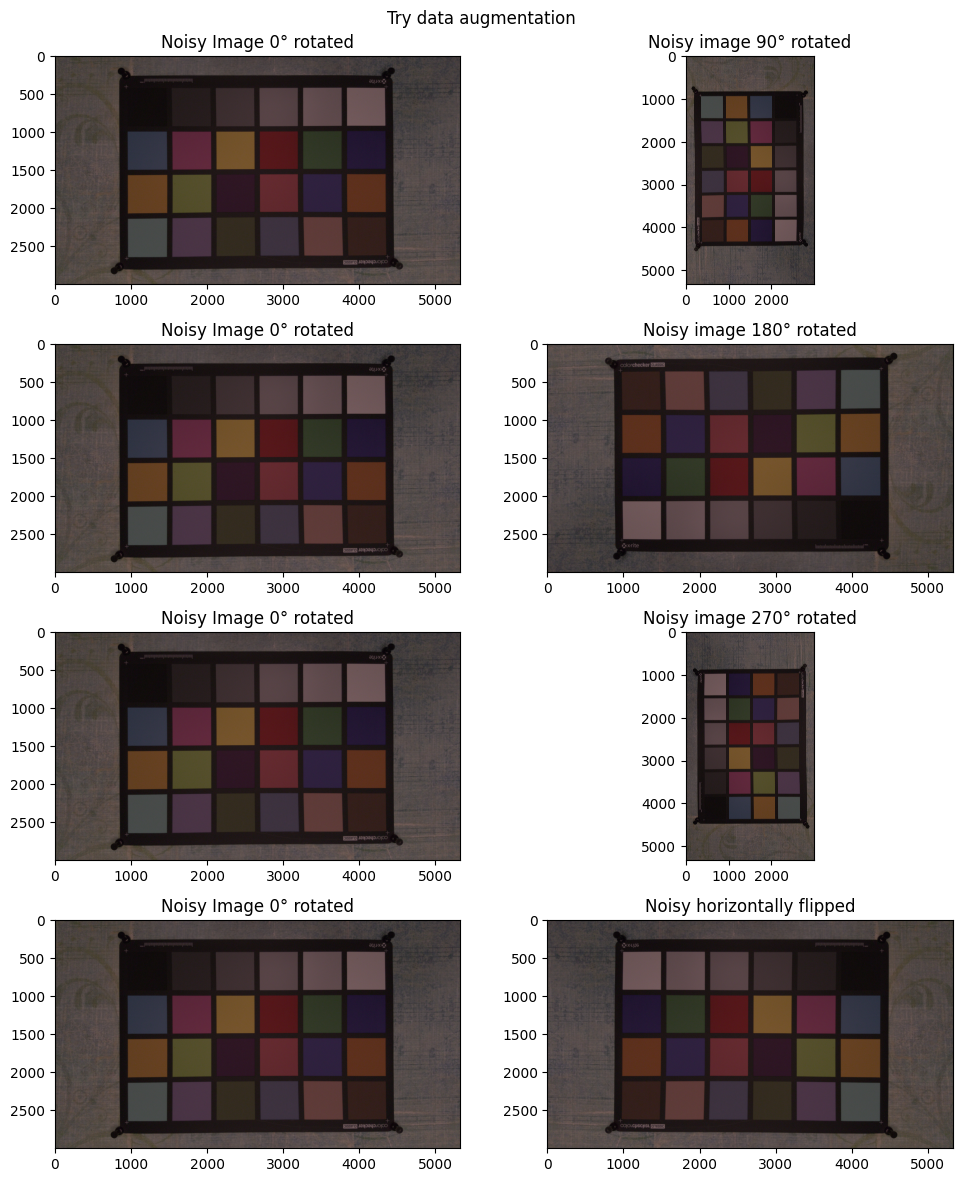

In [ ]:
flip90_img, _ = rotate90(raw_noise_img,raw_gt_img)
flip180_img, _ = rotate180(raw_noise_img,raw_gt_img)
flip270_img, _ = rotate270(raw_noise_img,raw_gt_img)
horiz_img, _ = horizontal_flip(raw_noise_img,raw_gt_img)

fig, ax = plt.subplots(4,2,figsize=(10,12))
fig.suptitle("Try data augmentation")
ax[0,0].set_title("Noisy Image 0° rotated")
ax[0,0].imshow(raw_noise_img)

ax[0,1].set_title("Noisy image 90° rotated")
ax[0,1].imshow(flip90_img)

ax[1,0].set_title("Noisy Image 0° rotated")
ax[1,0].imshow(raw_noise_img)

ax[1,1].set_title("Noisy image 180° rotated")
ax[1,1].imshow(flip180_img)

ax[2,0].set_title("Noisy Image 0° rotated")
ax[2,0].imshow(raw_noise_img)

ax[2,1].set_title("Noisy image 270° rotated")
ax[2,1].imshow(flip270_img)

ax[3,0].set_title("Noisy Image 0° rotated")
ax[3,0].imshow(raw_noise_img)

ax[3,1].set_title("Noisy horizontally flipped")
ax[3,1].imshow(horiz_img)

fig.tight_layout()
plt.show()

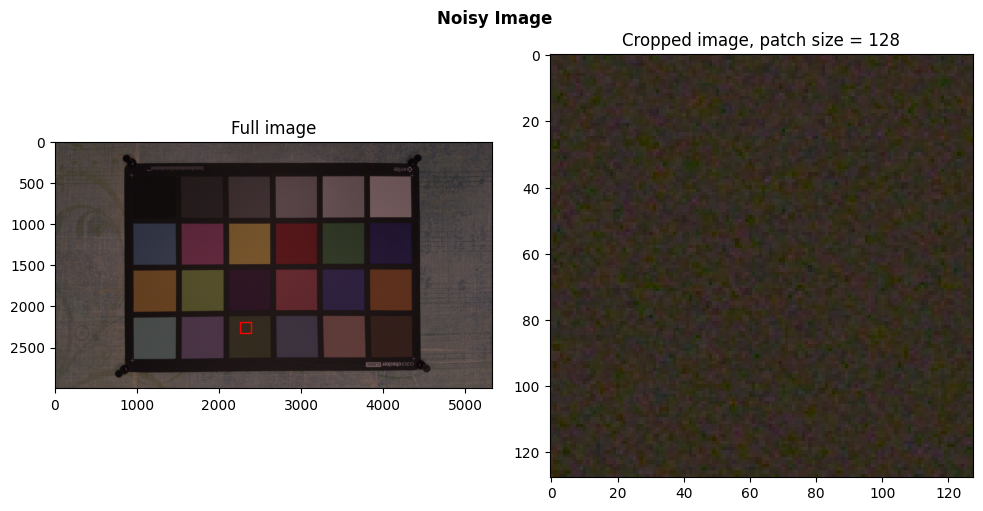

In [ ]:
ns_img = mpimg.imread(ns_path)

x_start = crop_x[0]
y_start = crop_y[0]
rect = patches.Rectangle((x_start, y_start), global_var['patch_size'], global_var['patch_size'], linewidth=1, edgecolor='r', facecolor='none')

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Noisy Image",fontweight="bold")
ax[0].set_title("Full image")
ax[0].imshow(ns_img)
ax[0].add_patch(rect)

ax[1].set_title("Cropped image, patch size = %d" % (global_var['patch_size']))
ax[1].imshow(ns.permute(1,2,0))

fig.tight_layout()
plt.show()

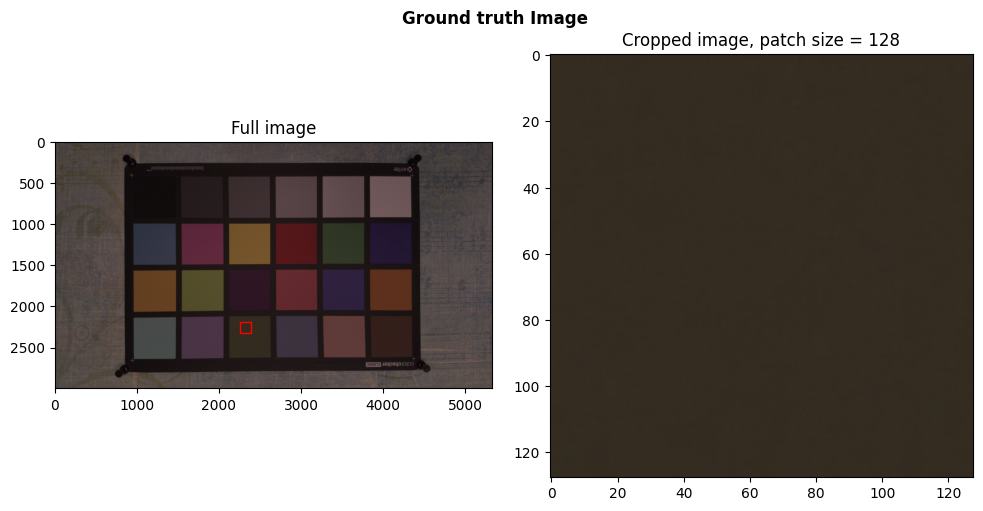

In [ ]:
gt_img = mpimg.imread(gt_path)

x_start = crop_x[0]
y_start = crop_y[0]
rect = patches.Rectangle((x_start, y_start), global_var['patch_size'], global_var['patch_size'], linewidth=1, edgecolor='r', facecolor='none')

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Ground truth Image",fontweight="bold")
ax[0].set_title("Full image")
ax[0].imshow(ns_img)
ax[0].add_patch(rect)

ax[1].set_title("Cropped image, patch size = %d" % (global_var['patch_size']))
ax[1].imshow(gt.permute(1,2,0))

fig.tight_layout()
plt.show()

# Loss
This section presents Charbonnier loss [6], which compares the restored image with ground truth. This function is often used in image restoration contexts.

## Charbonnier loss
Given an image $\textbf{I}\in\mathbb{R}^{3\times H\times W}$, the output of Uformer will be the restored image $\textbf{I}+\textbf{R}=\textbf{I}^{'}\in\mathbb{R}^{3\times H\times W}$, where $\textbf{R}$ is the residual image, the output of the Uformer decoder state. Given the ground truth $\textbf{I}^{'}\in\mathbb{R}^{3\times H\times W}$, the Charbonnier loss compares $\textbf{I}^{'}$ and $\textbf{I}^{*}$ in the following way
<br>
<br>
$$\mathcal{L}(\textbf{I}^{'},\textbf{I}^{*}) = \sqrt{\lVert{\textbf{I}^{'}-\textbf{I}^{*}}\lVert^{2}+\epsilon^{2}}.$$
<br>
Where $\epsilon$ is a constant equal to $10^{-3}$

In [ ]:
class Cha_loss(nn.Module):
  def __init__(self, epsilon=1e-3):
    super(Cha_loss,self).__init__()
    self.epsilon = epsilon

  def forward(self,pred,truth):
    return torch.mean(torch.sqrt((pred-truth)**2 + self.epsilon**2))

# Evaluation metrics
Here the canonical image restoration measures are implemented to evaluate the performance of the model.

## Peak Signal-to-Noise Ratio (PSNR)
Measures the quality of a compressed image by the ratio of the maximum value that image pixels can acquire to the value of noise in the image. Given the fact that we are working with Pythorch, the maximum pixel value in this format is 1.0, as opposed to the standard value of 255.
<br><br>
$$PSNR = 20 * \log_{10}\left(\frac{1.0}{\sqrt{\mathit{MSE}(\textbf{I}^{'},\textbf{I}^{*})}}\right).$$
<br>
In this formula, $\textbf{I}$ is the image passed as input, and $\mathit{MSE}(\textbf{I}^{'},\textbf{I}^{*})$ is the Mean Squared Error between the image relative to the ground truth and the restored image


In [ ]:
def psnr(original_img, restored_img, max_pix_val=1.0):
  mse = torch.mean((original_img-restored_img)**2)
  return 20 * torch.log10(max_pix_val/torch.sqrt(mse))

## Structural Similarity Index Measure (SSIM)
Consistent with its name, it measures the similarity between two images, in our case this measure for the ground truth image and the restored image, pixel-by-pixel [5], is:
<br><br>
$$\mathit{SSIM}(x,y)=\left(\textit{l}(x,y)\right)^{\alpha}*\left(\textit{c}(x,y)\right)^{\beta}*\left(\textit{s}(x,y)\right)^{\gamma}.$$

The expanded components of this formula are:
<br><br>
* _Luminance_: $$\textit{l}(x,y)=\frac{2 \mu_{\textbf{I}^{*}} \mu_{\textbf{I}^{'}} + C_1}{\mu_{\textbf{I}^{*}}^{2} \mu_{\textbf{I}^{'}}^{2} + C_1}.$$
<br><br>
* _Constrast_: $$\textit{c}(x,y)=\frac{2 \sigma_{\textbf{I}^{*}} \sigma_{\textbf{I}^{'}} + C_2}{\sigma_{\textbf{I}^{*}}^{2} \sigma_{\textbf{I}^{'}}^{2} + C_2}.$$
<br><br>
* _Structure_: $$\textit{s}(x,y)=\frac{\sigma_{\textbf{I}^{*}\textbf{I}^{'}} + C_3}{\sigma_{\textbf{I}^{*}} \sigma_{\textbf{I}^{'}} + C_3}.$$

A Gaussian window that also considers neighbors of the current pixel is used to calculate the mean, variance, and covariance. The latter tool uses a $11\times11$ kernel and has a standard deviation $\sigma=1.5$.

The $C$ constants are calculated in as follows:
*   $C_1=0.01*L$
*   $C_2=0.03*L$
*   $C_3=\frac{C_2}{2}$

Where $L$ is the maximum value a pixel can take, so, as mentioned above, in our case we will have $L=1.0$.

At the end of this analysis, by setting $\alpha=\beta=\gamma=1$ as in [5], we get a more compact version of the SSIM measure, which is the one actually applied:
<br><br>
$$\mathit{SSIM}(x,y)=\frac{(2 \mu_{\textbf{I}^{*}} \mu_{\textbf{I}^{'}} + C_1)(2 \sigma_{\textbf{I}^{*}\textbf{I}^{'}} + C_2)}{(\mu_{\textbf{I}^{*}}^{2}+\mu_{\textbf{I}^{'}}^{2} + C_1)(\sigma_{\textbf{I}^{*}}^{2}+\sigma_{\textbf{I}^{'}}^{2} + C_2)}$$
<br>

In [ ]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(original_img, restored_img, max_pix_val=1.0, window_size=11, window=None, size_average=True, full=False):
    (_, channel, height, width) = original_img.size()
    real_size = min(window_size, height, width)
    window = create_window(real_size, channel=channel).to(original_img.device)

    mu1 = F.conv2d(original_img, window, padding=0, groups=channel)
    mu2 = F.conv2d(restored_img, window, padding=0, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(original_img ** 2, window, padding=0, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(restored_img ** 2, window, padding=0, groups=channel) - mu2_sq
    sigma12 = F.conv2d(original_img * restored_img, window, padding=0, groups=channel) - mu1_mu2

    C1 = (0.01 * max_pix_val) ** 2
    C2 = (0.03 * max_pix_val) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2

    return (((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)).mean()


def compute_evaluation(test_dataloader, model, device='cpu'):
  model.eval()
  psnr_values = []
  ssim_values = []

  for _, (inputs, targets) in enumerate(test_dataloader):
      inputs, targets = inputs.to(device), targets.to(device)

      with torch.no_grad():
          predictions = model(inputs)

      psnr_values.append(psnr(targets,predictions))
      ssim_values.append(ssim(targets,predictions))

  return torch.mean(torch.Tensor(psnr_values)).item(),torch.mean(torch.Tensor(ssim_values)).item()

# Architecture
This part contains the entire Uformer architecture. However, this block is nondescript and is mainly used to run the program. The most accurate description of the architecture can be found in the following section.

## Auxiliary functions

In [ ]:
def get_windows(feature_map,window_size,debug=False):
  feat_batch, feat_channels, feat_height, feat_width = feature_map.shape
  window_number = int(feat_height*feat_width/(window_size**2))
  old_batch = feat_batch
  if(debug):
    print("Feature map shape = (Batch, Channels, Height, Width) = ",feature_map.shape)
    print("(Square) Window size = M =",window_size)
    print("Windows number = H*W/M^2 =",window_number)

  binded_windows = F.unfold(feature_map, kernel_size=window_size, stride=window_size) # (Batch, Channels*Height*Width/Num_windows, Num_windows)
  if(debug):
    print("Binded windows shape = (Batch, Channels*Height*Width/Num_windows, Num_windows) =",binded_windows.shape)

  mixed_windows = binded_windows.view(feat_batch, feat_channels, window_size, window_size, window_number)  # (Batch, Feat_Channels, Win_Height, Win_Width, Num_windows)
  if(debug):
    print("Mixed windows shape = (Batch, Feat_Channels, Win_Height, Win_Width, Num_windows) =",mixed_windows.shape)

  windows = mixed_windows.permute(0, 4, 1, 2, 3)  # (Batch, Num_windows, Feat_Channels, Win_Height, Win_Width)
  if(debug):
    print("Correct windows = (Batch, Num_windows, Feat_Channels, Win_Height, Win_Width) =",windows.shape)

  flattened_windows = torch.flatten(windows,start_dim=3)
  if(debug):
    print("Flattened windows = (Batch, Num_windows, Feat_Channels, Win_Height*Win_Width) =",flattened_windows.shape)

  transposed_windows = torch.transpose(flattened_windows,2,3)
  if(debug):
    print("Transposed windows = (Batch, Num_windows, Win_Height*Win_Width, Feat_Channels) =",transposed_windows.shape)

  final_windows = transposed_windows.contiguous().view(feat_batch*window_number,window_size*window_size,feat_channels)
  if(debug):
    print("Final windows = (Batch*Num_windows, Win_Height*Win_Width, Feat_Channels) =",final_windows.shape)

  return final_windows, old_batch

def window_semi_encoded(windows,windows_size):
    x = windows.view(windows.shape[0], 1, 1, windows_size, windows_size, -1) # SPIEGA
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(windows.shape[0], windows_size, windows_size, -1)
    return x

def back_to_patch(enc_windows,feats_channels,old_batch):
  batch_size = old_batch
  windows_number = enc_windows.shape[0]//batch_size
  windows_size = enc_windows.shape[1]
  patch_height = int(math.sqrt(windows_number*(windows_size**2)))
  patch_width = int(math.sqrt(windows_number*(windows_size**2)))

  restored_patch = enc_windows.view(batch_size, feats_channels, patch_height, patch_width)
  return restored_patch

def relative_embedding(window_size):
  coords_h = torch.arange(window_size)
  coords_w = torch.arange(window_size)
  coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
  coords_flatten = torch.flatten(coords, 1)
  relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
  relative_coords = relative_coords.permute(1, 2, 0).contiguous()
  relative_coords[:, :, 0] += window_size - 1
  relative_coords[:, :, 1] += window_size - 1
  relative_coords[:, :, 0] *= 2 * window_size - 1
  relative_position_index = relative_coords.sum(-1)

  return relative_position_index

def get_relative_position_bias(window_size,relative_position_table,relative_position_index,pre_soft_attn):
  relative_position_bias = relative_position_table[relative_position_index.view(-1)].view(
            window_size * window_size, window_size * window_size, -1)
  relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
  ratio = pre_soft_attn.size(-1)//relative_position_bias.size(-1)
  relative_position_bias = repeat(relative_position_bias, 'nH l c -> nH l (c d)', d = ratio)

  return relative_position_bias

## Functional blocks

In [ ]:
class InputProjection(nn.Module):
  def __init__(self,image_channels,projection_channels):
    super(InputProjection,self).__init__()

    self.low_level_filter = nn.Conv2d(image_channels,projection_channels,kernel_size=3,padding=1)
    self.proj_act = nn.LeakyReLU(inplace=True)

  def forward(self,x):
    x = self.low_level_filter(x)
    low_level_features = self.proj_act(x)
    return low_level_features

class Modulator(nn.Module):
  def __init__(self, window_size, feats_channels):
    super(Modulator,self).__init__()
    self.window_size = window_size
    self.feats_channels = feats_channels
    self.window_dim = window_size*window_size

    self.modulator = nn.Embedding(self.window_dim,self.feats_channels)

  def forward(self,x):
    return x + self.modulator.weight

class QKV(nn.Module):
    def __init__(self, features_channels, num_heads, dim_head):
        super(QKV, self).__init__()
        self.num_heads = num_heads
        self.dim_head = dim_head
        self.features_channels = features_channels
        self.get_qkv = nn.Linear(features_channels, 3*num_heads*dim_head)

    def forward(self, x):
        seq_len, input_dim, channels = x.shape
        qkv = self.get_qkv(x)
        qkv = qkv.reshape(seq_len, input_dim, self.num_heads, 3*self.dim_head)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)

        return q,k,v

class WindowAttention(nn.Module):
    def __init__(self, features_channels, window_size,num_heads):
        super().__init__()
        self.features_channels = features_channels
        self.window_size = window_size
        self.num_heads = num_heads
        self.head_dim = self.features_channels // self.num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = QKV(self.features_channels,num_heads,self.features_channels//num_heads)
        self.proj = nn.Linear(self.features_channels, self.features_channels)
        self.drop_1 = nn.Dropout(0.2)
        self.drop_2 = nn.Dropout(0.2)
        self.get_attention_scores = nn.Softmax(dim=-1)
        self.relative_position_dim = (2 * self.window_size - 1) ** 2
        self.relative_position_bias_table = nn.Parameter(torch.zeros(self.relative_position_dim, num_heads))
        self.relative_position_index = relative_embedding(self.window_size)

    def forward(self, x):
        batch_and_win, input_dim, channels = x.shape
        q, k, v = self.qkv(x)
        q = q*self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = get_relative_position_bias(self.window_size,self.relative_position_bias_table,self.relative_position_index,attn)

        attn = attn + relative_position_bias.unsqueeze(0)
        attn = self.get_attention_scores(attn)
        attn = self.drop_1(attn)

        x = (attn @ v).transpose(1, 2).reshape(batch_and_win, input_dim, channels)
        x = self.proj(x)
        x = self.drop_2(x)

        return x

class LeFF(nn.Module):
  def __init__(self, feats_channels, hidden_channels):
    super(LeFF,self).__init__()
    self.fc1 = nn.Linear(feats_channels,hidden_channels)
    self.conv = nn.Conv2d(hidden_channels,hidden_channels,kernel_size=3,padding=1)
    self.fc2 = nn.Linear(hidden_channels,feats_channels)
    self.act_1 = nn.GELU()
    self.act_2 = nn.GELU()

  def forward(self,x):
    x = self.fc1(x)
    x = self.act_1(x)

    x = torch.transpose(x,1,3)
    x = self.conv(x)
    x = self.act_2(x)

    x = torch.transpose(x,1,3)
    x = self.fc2(x)

    return x

class LeWinTransformer(nn.Module):
  def __init__(self,features_channels,window_size,num_heads,encoder):
    super(LeWinTransformer,self).__init__()
    self.window_size = window_size
    self.encoder = encoder
    self.wind_attn = WindowAttention(features_channels,window_size,num_heads)
    self.layer_norm_1 = nn.LayerNorm(features_channels)
    self.layer_norm_2 = nn.LayerNorm(features_channels)
    self.leff = LeFF(features_channels,features_channels)
    self.mod = Modulator(window_size,features_channels)

  def forward(self,x):
    lewin_res = x

    x,old_batch = get_windows(x,self.window_size,debug=False)
    x = self.layer_norm_1(x)
    if(not self.encoder):
      x = self.mod(x)

    x_attn = window_semi_encoded(self.wind_attn(x),self.window_size)
    x_attn_res = window_semi_encoded(x,self.window_size)
    x_res = x_attn + x_attn_res

    x_res_norm = self.layer_norm_2(x_res)
    x = x_res + self.leff(x_res_norm)
    x = back_to_patch(x,x.shape[-1],old_batch)

    return x

class DownSampler(nn.Module):
  def __init__(self,transformer_channels,map_channels):
    super(DownSampler,self).__init__()
    self.conv = nn.Conv2d(transformer_channels,map_channels,kernel_size=4,stride=2,padding=1)

  def forward(self,x):
    x = self.conv(x)
    return x

class UpSampler(nn.Module):
  def __init__(self,transformer_channels,map_channels):
    super(UpSampler,self).__init__()
    self.transp_conv = nn.ConvTranspose2d(transformer_channels,map_channels,kernel_size=2,stride=2)

  def forward(self,x):
    x = self.transp_conv(x)
    return x

class OutputProjection(nn.Module):
  def __init__(self,features_channels,image_channels):
    super(OutputProjection,self).__init__()

    self.restore_filter = nn.Conv2d(features_channels,image_channels,kernel_size=3,padding=1)
    self.proj_act = nn.LeakyReLU(inplace=True)

  def forward(self,x):
    x = self.restore_filter(x)
    residual_image = self.proj_act(x)
    return residual_image

## Uformer full architecture

In [ ]:
class Uformer(nn.Module):
  def __init__(self,image_channels,features_channels,window_size,num_heads,no_mod=False):
    super(Uformer,self).__init__()
    self.in_proj = InputProjection(image_channels,features_channels)

    self.transformer_01 = LeWinTransformer(features_channels,window_size,num_heads[0],encoder=True)
    self.transformer_1 = LeWinTransformer(features_channels,window_size,num_heads[0],encoder=True)
    self.downsampling_1 = DownSampler(features_channels,features_channels*2)

    self.transformer_02 = LeWinTransformer(features_channels*2,window_size,num_heads[1],encoder=True)
    self.transformer_2 = LeWinTransformer(features_channels*2,window_size,num_heads[1],encoder=True)
    self.downsampling_2 = DownSampler(features_channels*2,features_channels*4)

    self.transformer_03 = LeWinTransformer(features_channels*4,window_size,num_heads[2],encoder=True)
    self.transformer_3 = LeWinTransformer(features_channels*4,window_size,num_heads[2],encoder=True)
    self.downsampling_3 = DownSampler(features_channels*4,features_channels*8)

    self.transformer_04 = LeWinTransformer(features_channels*8,window_size,num_heads[3],encoder=True)
    self.transformer_4 = LeWinTransformer(features_channels*8,window_size,num_heads[3],encoder=True)
    self.downsampling_4 = DownSampler(features_channels*8,features_channels*16)

    self.bottleneck_0 = LeWinTransformer(features_channels*16,window_size,num_heads[4],encoder=True)
    self.bottleneck = LeWinTransformer(features_channels*16,window_size,num_heads[4],encoder=True)

    self.upsampling_1 = UpSampler(features_channels*16,features_channels*8)
    self.transformer_05 = LeWinTransformer(features_channels*16,window_size,num_heads[4],encoder=no_mod)
    self.transformer_5 = LeWinTransformer(features_channels*16,window_size,num_heads[4],encoder=no_mod)

    self.upsampling_2 = UpSampler(features_channels*16,features_channels*4)
    self.transformer_06 = LeWinTransformer(features_channels*8,window_size,num_heads[3],encoder=no_mod)
    self.transformer_6 = LeWinTransformer(features_channels*8,window_size,num_heads[3],encoder=no_mod)

    self.upsampling_3 = UpSampler(features_channels*8,features_channels*2)
    self.transformer_07 = LeWinTransformer(features_channels*4,window_size,num_heads[2],encoder=no_mod)
    self.transformer_7 = LeWinTransformer(features_channels*4,window_size,num_heads[2],encoder=no_mod)

    self.upsampling_4 = UpSampler(features_channels*4,features_channels)
    self.transformer_08 = LeWinTransformer(features_channels*2,window_size,num_heads[1],encoder=no_mod)
    self.transformer_8 = LeWinTransformer(features_channels*2,window_size,num_heads[1],encoder=no_mod)

    self.out_proj = OutputProjection(features_channels*2,image_channels)

  def forward(self,x):
    proj_x = self.in_proj(x)

    t01 = self.transformer_01(proj_x)
    t1 = self.transformer_1(t01)

    d1 = self.downsampling_1(t1)

    t02 = self.transformer_02(d1)
    t2 = self.transformer_2(t02)

    d2 = self.downsampling_2(t2)

    t03 = self.transformer_03(d2)
    t3 = self.transformer_3(t03)

    d3 = self.downsampling_3(t3)

    t04 = self.transformer_04(d3)
    t4 = self.transformer_4(t04)

    d4 = self.downsampling_4(t4)

    btl_0 = self.bottleneck_0(d4)
    btl = self.bottleneck(btl_0)

    u1 = self.upsampling_1(btl)
    skip1 = torch.cat([u1,t4],1)
    t05 = self.transformer_05(skip1)
    t5 = self.transformer_5(t05)

    u2 = self.upsampling_2(t5)
    skip2 = torch.cat([u2,t3],1)
    t06 = self.transformer_06(skip2)
    t6 = self.transformer_6(t06)

    u3 = self.upsampling_3(t6)
    skip3 = torch.cat([u3,t2],1)
    t07 = self.transformer_07(skip3)
    t7 = self.transformer_7(t07)

    u4 = self.upsampling_4(t7)
    skip4 = torch.cat([u4,t1],1)
    t08 = self.transformer_08(skip4)
    t8 = self.transformer_8(t08)

    out = self.out_proj(t8)

    return out + x

# Detailed architecture
This section briefly but exhaustively describes each component of the Uformer structure. All of these components, taken together, will form the architecture depicted in the image below
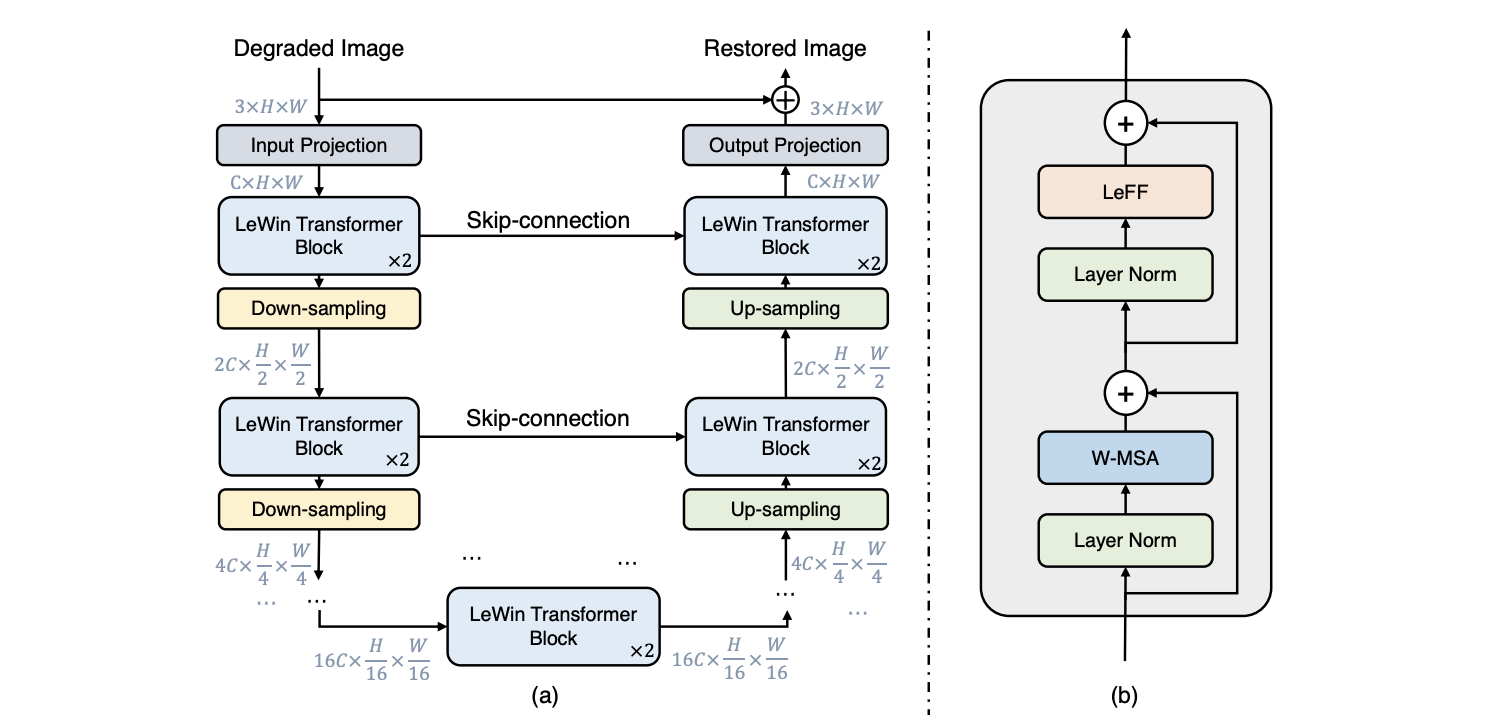

The blocks will be described in the order in which they appear following the forward direction of the network.

## [Encoder] Input Projection
Initial block of the structure. Given the degraded (noisy) image $\textbf{I}\in\mathbb{R}^{3\times H\times W}$, it extracts a feature map containing low level features with a number of output channels depending on the type of Uformer. We need a padding 1 tin our convolutional layer to mantain the same H and W of the input.

In [ ]:
class InputProjection(nn.Module):
  def __init__(self,image_channels,projection_channels):
    super(InputProjection,self).__init__()

    self.low_level_filter = nn.Conv2d(image_channels,projection_channels,kernel_size=3,padding=1)
    self.proj_act = nn.LeakyReLU(inplace=True)

  def forward(self,x):
    x = self.low_level_filter(x)
    low_level_features = self.proj_act(x)
    return low_level_features

To see how this module behaves, we submit an example from the dataloader to the latter.

In [ ]:
noisy, target = train_dataset.__getitem__(10)
noisy.shape

torch.Size([3, 128, 128])

Set channels to 3 just to highlights extracted features

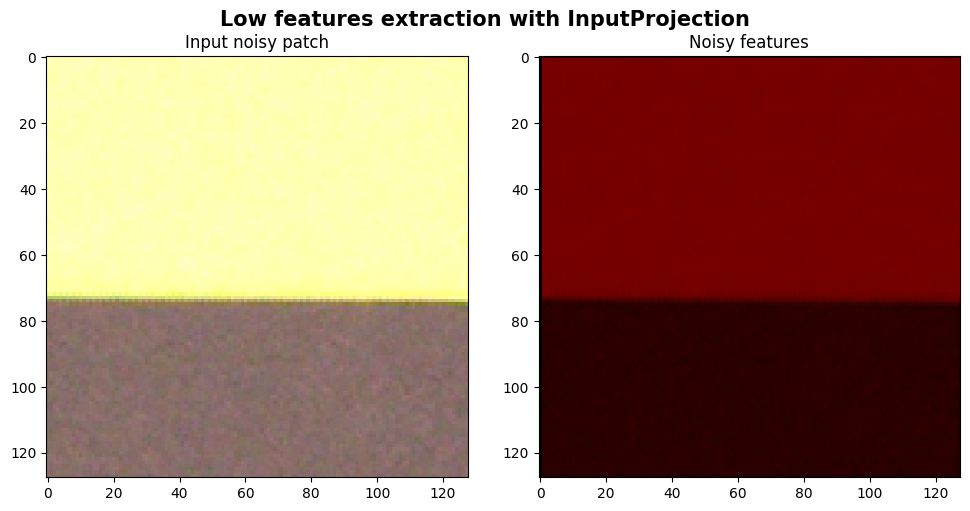

In [ ]:
ip = InputProjection(image_channels=noisy.shape[0],projection_channels=3)
noisy_feats = ip(noisy.unsqueeze(0))

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Low features extraction with InputProjection",size=15,fontweight="bold")
ax[0].set_title("Input noisy patch")
ax[0].imshow(noisy.permute(1,2,0))

ax[1].set_title("Noisy features")
ax[1].imshow(noisy_feats[0].detach().permute(1,2,0))

fig.tight_layout()
plt.show()

For a number of channels consistent with a real application of the module, we obtain the following

In [ ]:
noisy_batch, target_batch = next(iter(train_loader))

ip = InputProjection(image_channels=noisy_batch.shape[1],projection_channels=16)
real_noisy_feats = ip(noisy_batch)
print("Projected feature map shape: ",real_noisy_feats.shape)

Projected feature map shape:  torch.Size([32, 16, 128, 128])


## [Encoder/Decoder] Window-based Multi-head Self-Attentions (W-MSA)
Self-attention mechanism can capture long-range dependencies, but has some problems in its computational cost [7,8], as the latter has complexity $\mathcal{O}(n^2d)$ [7], where $n$ is the length of the input sequence and $d$ is the representation dimension. So, in our case, the complexity is $\mathcal{O}(H^2W^2C)$ [1].

The strategy of [1] to mitigate this problem is to compute attention by exploiting non-overlapping windows applied on the input. Such windows have size $M$ and are square.

This operation greatly reduces the computational cost of self-attention, as the input $\textbf{X}\in\mathbb{R}^{C\times H \times W}$ is divided among $N = \frac{HW}{M^2}$ windows, and each one computes attention independently on the flattened and transposed portion $\textbf{X}^{i}\in \mathbb{R}^{M^2\times C}$. So, the actual complexity becomes $\mathcal{O}(M^2HWC)$ [1].

Another special feature introduced by [1] is the addition of a relative position bias $\textbf{B}$. For design reasons, after several attempts, we were forced to take the code for this encoding from the authors of the paper.

Moreover, the paper [1] proposes a multi-head attention approach, in which the size of heads $d_k$ is kept equal to the number of channels $C$.

To conclude the attention, for each window, will be calculated as
<br><br>
$$\mathit{Attention}(\mathbf{Q},\mathbf{K},\mathbf{V})=\mathit{SoftMax}\left(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d_k}}+\mathbf{B}\right)\mathbf{V}$$
<br>


In [ ]:
def relative_embedding(window_size):
  coords_h = torch.arange(window_size) # [0,...,Wh-1]
  coords_w = torch.arange(window_size) # [0,...,Ww-1]
  coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
  coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
  relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
  relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
  relative_coords[:, :, 0] += window_size - 1  # shift to start from 0
  relative_coords[:, :, 1] += window_size - 1
  relative_coords[:, :, 0] *= 2 * window_size - 1
  relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww

  return relative_position_index

def get_relative_position_bias(window_size,relative_position_table,relative_position_index,pre_soft_attn):
  relative_position_bias = relative_position_table[relative_position_index.view(-1)].view(
            window_size * window_size, window_size * window_size, -1)  # Wh*Ww,Wh*Ww,nH
  relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
  ratio = pre_soft_attn.size(-1)//relative_position_bias.size(-1)
  relative_position_bias = repeat(relative_position_bias, 'nH l c -> nH l (c d)', d = ratio)

  return relative_position_bias

In [ ]:
def get_windows(feature_map,window_size,debug=False):
  feat_batch, feat_channels, feat_height, feat_width = feature_map.shape
  window_number = int(feat_height*feat_width/(window_size**2))
  old_batch = feat_batch
  if(debug):
    print("Feature map shape = (Batch, Channels, Height, Width) = ",feature_map.shape)
    print("(Square) Window size = M =",window_size)
    print("Windows number = H*W/M^2 =",window_number)

  # With this operation we obtain the wanted number of windows, but they are somehow binded all together
  binded_windows = F.unfold(feature_map, kernel_size=window_size, stride=window_size) # (Batch, Channels*Height*Width/Num_windows, Num_windows)
  if(debug):
    print("Binded windows shape = (Batch, Channels*Height*Width/Num_windows, Num_windows) =",binded_windows.shape)

  # Now we need some operations in order to obtain a tensor [Batch, Num_windows, Feat_Channels, Win_Height, Win_Width]
  mixed_windows = binded_windows.view(feat_batch, feat_channels, window_size, window_size, window_number)  # (Batch, Feat_Channels, Win_Height, Win_Width, Num_windows)
  if(debug):
    print("Mixed windows shape = (Batch, Feat_Channels, Win_Height, Win_Width, Num_windows) =",mixed_windows.shape)

  windows = mixed_windows.permute(0, 4, 1, 2, 3)  # (Batch, Num_windows, Feat_Channels, Win_Height, Win_Width)
  if(debug):
    print("Correct windows = (Batch, Num_windows, Feat_Channels, Win_Height, Win_Width) =",windows.shape)

  # As the paper suggests, we need flattened windows to apply self-attention
  flattened_windows = torch.flatten(windows,start_dim=3)
  if(debug):
    print("Flattened windows = (Batch, Num_windows, Feat_Channels, Win_Height*Win_Width) =",flattened_windows.shape)

  transposed_windows = torch.transpose(flattened_windows,2,3)
  if(debug):
    print("Transposed windows = (Batch, Num_windows, Win_Height*Win_Width, Feat_Channels) =",transposed_windows.shape)

  # As paper request, we bind batch size and windows number
  final_windows = transposed_windows.contiguous().view(feat_batch*window_number,window_size*window_size,feat_channels)
  if(debug):
    print("Final windows = (Batch*Num_windows, Win_Height*Win_Width, Feat_Channels) =",final_windows.shape)

  return final_windows, old_batch

To elaborate on what has been done, just apply it to an example

In [ ]:
windowed_patch, old_batch = get_windows(real_noisy_feats,8,debug=True)

Feature map shape = (Batch, Channels, Height, Width) =  torch.Size([32, 16, 128, 128])
(Square) Window size = M = 8
Windows number = H*W/M^2 = 256
Binded windows shape = (Batch, Channels*Height*Width/Num_windows, Num_windows) = torch.Size([32, 1024, 256])
Mixed windows shape = (Batch, Feat_Channels, Win_Height, Win_Width, Num_windows) = torch.Size([32, 16, 8, 8, 256])
Correct windows = (Batch, Num_windows, Feat_Channels, Win_Height, Win_Width) = torch.Size([32, 256, 16, 8, 8])
Flattened windows = (Batch, Num_windows, Feat_Channels, Win_Height*Win_Width) = torch.Size([32, 256, 16, 64])
Transposed windows = (Batch, Num_windows, Win_Height*Win_Width, Feat_Channels) = torch.Size([32, 256, 64, 16])
Final windows = (Batch*Num_windows, Win_Height*Win_Width, Feat_Channels) = torch.Size([8192, 64, 16])


In [ ]:
class QKV(nn.Module):
    def __init__(self, features_channels, num_heads, dim_head):
        super(QKV, self).__init__()
        self.num_heads = num_heads
        self.dim_head = dim_head
        self.features_channels = features_channels
        self.get_qkv = nn.Linear(features_channels, 3*num_heads*dim_head)

    def forward(self, x):
        seq_len, input_dim, channels = x.shape
        qkv = self.get_qkv(x)
        qkv = qkv.reshape(seq_len, input_dim, self.num_heads, 3*self.dim_head)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)

        return q,k,v

class WindowAttention(nn.Module):
    def __init__(self, features_channels, window_size,num_heads):
        super().__init__()
        self.features_channels = features_channels
        self.window_size = window_size
        self.num_heads = num_heads
        self.head_dim = self.features_channels // self.num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = QKV(self.features_channels,num_heads,self.features_channels//num_heads)
        self.proj = nn.Linear(self.features_channels, self.features_channels)
        self.drop_1 = nn.Dropout(0.)
        self.drop_2 = nn.Dropout(0.)
        self.get_attention_scores = nn.Softmax(dim=-1)
        self.relative_position_dim = (2 * self.window_size - 1) ** 2
        self.relative_position_bias_table = nn.Parameter(torch.zeros(self.relative_position_dim, num_heads))
        self.relative_position_index = relative_embedding(self.window_size)

    def forward(self, x):
        batch_and_win, input_dim, channels = x.shape
        q, k, v = self.qkv(x)
        q = q*self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = get_relative_position_bias(self.window_size,self.relative_position_bias_table,self.relative_position_index,attn)

        attn = attn + relative_position_bias.unsqueeze(0)
        attn = self.get_attention_scores(attn)
        attn = self.drop_1(attn)

        x = (attn @ v).transpose(1, 2).reshape(batch_and_win, input_dim, channels)
        x = self.proj(x)
        x = self.drop_2(x)

        return x

### [Decoder] Modulator
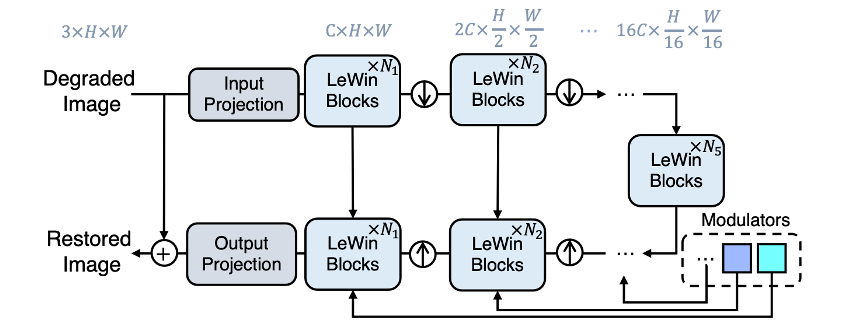

This module is simply a learnable tensor added as a bias term to each window, prior to the application of attention. This approach promotes the retrieval of more detail and is activated in the decoder structure.

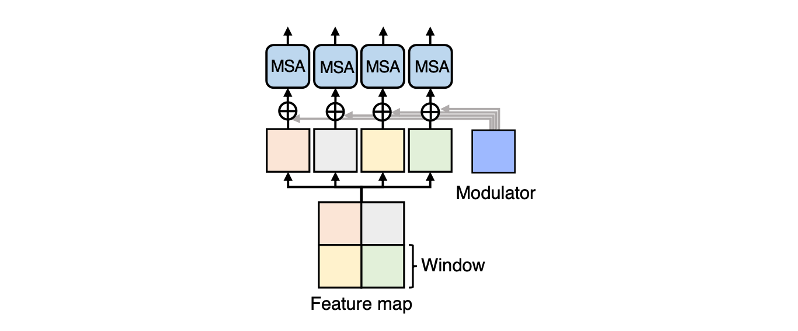

In [ ]:
class Modulator(nn.Module):
  def __init__(self, window_size, feats_channels): #dim = feats_channels
    super(Modulator,self).__init__()
    self.window_size = window_size
    self.feats_channels = feats_channels
    self.window_dim = window_size*window_size

    self.modulator = nn.Embedding(self.window_dim,self.feats_channels)

  def forward(self,x):
    return x + self.modulator.weight

In [ ]:
mod = Modulator(int(math.sqrt(windowed_patch.shape[1])),windowed_patch.shape[2])
att = WindowAttention(windowed_patch.shape[2],int(math.sqrt(windowed_patch.shape[1])),1)
att_mod = att(mod(windowed_patch))
print("Aaa shape: ",att_mod.shape)

Aaa shape:  torch.Size([8192, 64, 16])


## [Encoder/Decoder] Locally-enhanced Feed-Forward Network (LeFF)
Continuing to compose the Transformer structure, the next standard block would be a FeedForward Neural Network (FFN). However, the latter has limited capability in extracting local information, a fundamental concept in our application.

The authors of [1] solve this problem by making by adding a convolutional block to the FFN, manipulating the input and output in such a way as to remain consistent in size.

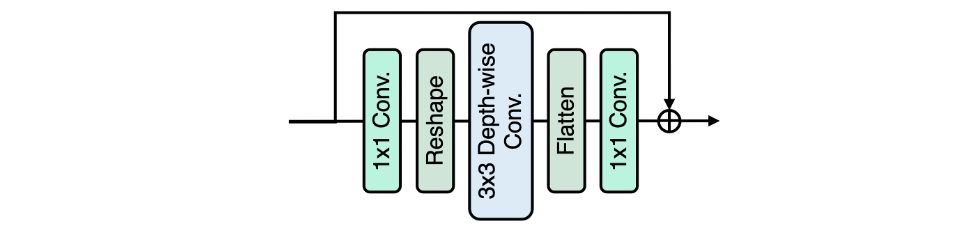

This process occurs on recompacted data, after they have been divided into patches in the attention window approach.

However, the data is not brought to its initial form. A sort of encoding is maintained so that the input channels of the LeFF block are reduced.

Only after passing through this block will we return to the initial dimensions, i.e., those before entering the attention module.

In [ ]:
def window_semi_encoded(windows,windows_size):
    x = windows.view(windows.shape[0], 1, 1, windows_size, windows_size, -1) # SPIEGA
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(windows.shape[0], windows_size, windows_size, -1)
    return x

In [ ]:
print("Pre Windows shape: ",real_noisy_feats.shape)
print("Windows shape: ",windowed_patch.shape)
back = window_semi_encoded(att_mod,int(math.sqrt(windowed_patch.shape[1])))
print("Back to patch shape: ",back.shape)

Pre Windows shape:  torch.Size([32, 16, 128, 128])
Windows shape:  torch.Size([8192, 64, 16])
Back to patch shape:  torch.Size([8192, 8, 8, 16])


In [ ]:
class LeFF(nn.Module):
  def __init__(self, feats_channels, hidden_channels):
    super(LeFF,self).__init__()
    self.fc1 = nn.Linear(feats_channels,hidden_channels)
    self.conv = nn.Conv2d(hidden_channels,hidden_channels,kernel_size=3,padding=1)
    self.fc2 = nn.Linear(hidden_channels,feats_channels)
    self.act_1 = nn.GELU()
    self.act_2 = nn.GELU()

  def forward(self,x):
    x = self.fc1(x)
    x = self.act_1(x)

    x = torch.transpose(x,1,3)
    x = self.conv(x)
    x = self.act_2(x)

    x = torch.transpose(x,1,3)
    x = self.fc2(x)

    return x

In [ ]:
leff = LeFF(back.shape[-1],back.shape[-1])
leff_out = leff(back)
print("Out LeFF shape: ",leff_out.shape)

Out LeFF shape:  torch.Size([8192, 8, 8, 16])


In [ ]:
def back_to_patch(enc_windows,feats_channels,old_batch):
  batch_size = old_batch
  # Remembering that in windowing process, the last step done num_wind*batch
  windows_number = enc_windows.shape[0]//batch_size
  windows_size = enc_windows.shape[1]
  # Remembering that num_win = H*W/M^2 + We are assuming to use ONLY squared windows + M is already squared in window shape
  patch_height = int(math.sqrt(windows_number*(windows_size**2)))
  patch_width = int(math.sqrt(windows_number*(windows_size**2)))

  restored_patch = enc_windows.view(batch_size, feats_channels, patch_height, patch_width)
  return restored_patch

In [ ]:
print(leff_out.shape)
restored_patch = back_to_patch(leff_out,leff_out.shape[-1],old_batch)
print("Restored patch shape: ", restored_patch.shape)

torch.Size([8192, 8, 8, 16])
Restored patch shape:  torch.Size([32, 16, 128, 128])


## [Encoder/Decoder] LeWin Transformer
The W-MSA and LeFF blocks form a classic Transformer architecture, with normalization layers and residual connections.
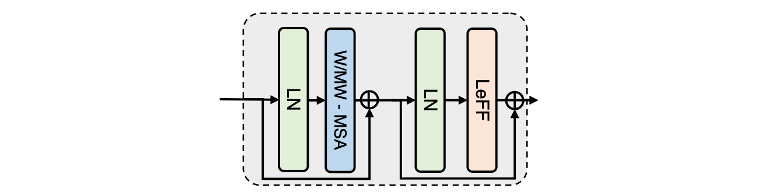

In [ ]:
class LeWinTransformer(nn.Module):
  def __init__(self,features_channels,window_size,num_heads,encoder):
    super(LeWinTransformer,self).__init__()
    self.window_size = window_size
    self.encoder = encoder
    self.wind_attn = WindowAttention(features_channels,window_size,num_heads)
    self.layer_norm_1 = nn.LayerNorm(features_channels)
    self.layer_norm_2 = nn.LayerNorm(features_channels)
    self.leff = LeFF(features_channels,features_channels)
    self.mod = Modulator(window_size,features_channels)

  def forward(self,x):
    lewin_res = x

    x,old_batch = get_windows(x,self.window_size,debug=False)
    x = self.layer_norm_1(x)
    if(not self.encoder):
      x = self.mod(x)

    x_attn = window_semi_encoded(self.wind_attn(x),self.window_size)
    x_attn_res = window_semi_encoded(x,self.window_size)
    x_res = x_attn + x_attn_res

    x_res_norm = self.layer_norm_2(x_res)
    x = x_res + self.leff(x_res_norm)
    x = back_to_patch(x,x.shape[-1],old_batch)

    return x

In [ ]:
print("Transformer input shape: ",real_noisy_feats.shape)
tf_block = LeWinTransformer(real_noisy_feats.shape[1],8,1,True)
tf_out = tf_block(real_noisy_feats)
print("Transformer output shape: ",tf_out.shape)

Transformer input shape:  torch.Size([32, 16, 128, 128])
Transformer output shape:  torch.Size([32, 16, 128, 128])


## [Encoder] Down-sampling block
A convolutional layer is applied on the input, which results in doubling the number of channels $C$ and halving the dimensions $H$ and $W$. Thus, at the encoder stage $\mathit{l}$
we will have after downsampling, feature maps $\mathbf{X}_l\in\mathbb{R}^{2^lC\times \frac{H}{2^l}\times \frac{W}{2^l}}$

In [ ]:
class DownSampler(nn.Module):
  def __init__(self,transformer_channels,map_channels):
    super(DownSampler,self).__init__()
    self.conv = nn.Conv2d(transformer_channels,map_channels,kernel_size=4,stride=2,padding=1)

  def forward(self,x):
    x = self.conv(x)
    return x

In [ ]:
print("Pre downsampled patch shape: ", tf_out.shape)
ds = DownSampler(tf_out.shape[1],tf_out.shape[1]*2)
downsampled_patch = ds(tf_out)
print("Downsampled patch shape: ", downsampled_patch.shape)

Pre downsampled patch shape:  torch.Size([32, 16, 128, 128])
Downsampled patch shape:  torch.Size([32, 32, 64, 64])


## Encoder
Composed of a series of LeWin Transformers blocks followed by a down-sampling block.

In [ ]:
class Encoder(nn.Module):
  def __init__(self,image_channels,features_channels,window_size,num_heads):
    super(Encoder,self).__init__()
    self.in_proj = InputProjection(image_channels,features_channels)

    self.transformer_1 = LeWinTransformer(features_channels,window_size,num_heads,encoder=True)
    self.downsampling_1 = DownSampler(features_channels,features_channels*2)

    self.transformer_2 = LeWinTransformer(features_channels*2,window_size,num_heads,encoder=True)
    self.downsampling_2 = DownSampler(features_channels*2,features_channels*4)

    self.transformer_3 = LeWinTransformer(features_channels*4,window_size,num_heads,encoder=True)
    self.downsampling_3 = DownSampler(features_channels*4,features_channels*8)

    self.transformer_4 = LeWinTransformer(features_channels*8,window_size,num_heads,encoder=True)
    self.downsampling_4 = DownSampler(features_channels*8,features_channels*16)

    # self.bottleneck = LeWinTransformer(features_channels*16,window_size,num_heads,encoder=True)

  def forward(self,x):
    list_out = []
    print("Input image shape: ",x.shape)

    x = self.in_proj(x)
    print("Projected input shape: ",x.shape)

    x = self.transformer_1(x)
    list_out.append(x)
    # print("Transformer 1 shape: ",x.shape)

    x = self.downsampling_1(x)
    # print("Downsampling 1 shape: ",x.shape)
    print("Output encoder block 1: ",x.shape)

    x = self.transformer_2(x)
    list_out.append(x)
    # print("Transformer 2 shape: ",x.shape)

    x = self.downsampling_2(x)
    # print("Downsampling 2 shape: ",x.shape)
    print("Output encoder block 1: ",x.shape)

    x = self.transformer_3(x)
    list_out.append(x)
    # print("Transformer 3 shape: ",x.shape)

    x = self.downsampling_3(x)
    # print("Downsampling 3 shape: ",x.shape)
    print("Output encoder block 3: ",x.shape)

    x = self.transformer_4(x)
    list_out.append(x)
    # print("Transformer 4 shape: ",x.shape)

    x = self.downsampling_4(x)
    # print("Downsampling 4 shape: ",x.shape)
    print("Output encoder block 4: ",x.shape)

    # x = self.bottleneck(x)
    # # print("Downsampling 4 shape: ",x.shape)
    # print("Output bottleneck block: ",x.shape)

    return x, list_out

In [ ]:
enc = Encoder(noisy_batch.shape[1],16,8,1)
out,list_outs = enc(noisy_batch)

Input image shape:  torch.Size([32, 3, 128, 128])
Projected input shape:  torch.Size([32, 16, 128, 128])
Output encoder block 1:  torch.Size([32, 32, 64, 64])
Output encoder block 1:  torch.Size([32, 64, 32, 32])
Output encoder block 3:  torch.Size([32, 128, 16, 16])
Output encoder block 4:  torch.Size([32, 256, 8, 8])


## Bottleneck
Between the end of the encoder and the beginning of the decoder, another LeWin Transformer block is placed. Its task is to capture long dependencies.

In [ ]:
print("Encoder out shape: ",out.shape)
btlnk = LeWinTransformer(out.shape[1],8,1,encoder=True)
out_btl = btlnk(out)
print("Bottlenek out shape: ",out.shape)

Encoder out shape:  torch.Size([32, 256, 8, 8])
Bottlenek out shape:  torch.Size([32, 256, 8, 8])


## [Decoder] Up-sampling block
It performs the opposite task of the Down-sampling block, coterminous with the reconstruction task associated with the stage decoder.

In [ ]:
class UpSampler(nn.Module):
  def __init__(self,transformer_channels,map_channels):
    super(UpSampler,self).__init__()
    self.transp_conv = nn.ConvTranspose2d(transformer_channels,map_channels,kernel_size=2,stride=2)

  def forward(self,x):
    x = self.transp_conv(x)
    return x

In [ ]:
print("Encoder output shape: ", out.shape)
ups = UpSampler(real_noisy_feats.shape[1]*16,real_noisy_feats.shape[1]*8)
upped = ups(out)
print("Upsample output shape: ", upped.shape)

Encoder output shape:  torch.Size([32, 256, 8, 8])
Upsample output shape:  torch.Size([32, 128, 16, 16])


## [Decoder] Output projection
This module is the last element of the architecture, and the decoder stage, and performs the opposite task of the Input Projection module. It returns as output the residual image $\textbf{R}\in\mathbb{R}^{3\times H\times W}$, again in the standard size for an image.

In [ ]:
# Output projection
# Projection channels = 16, 32
class OutputProjection(nn.Module):
  def __init__(self,features_channels,image_channels):
    super(OutputProjection,self).__init__()

    self.restore_filter = nn.Conv2d(features_channels,image_channels,kernel_size=3,padding=1)
    self.proj_act = nn.LeakyReLU(inplace=True)

  def forward(self,x):
    x = self.restore_filter(x)
    residual_image = self.proj_act(x)
    return residual_image

## Decoder
It performs the task of image reconstruction, starting from the bottleneck output. Each LeWin transformer block is preceded by an Up-Sampling block. Differently from the stage encoder, LeWin transformer blocks have a Modulator and receive a different input. In fact, they process the concatenation between
* Output of the Up-sampling block
* Output of the corresponding LeWin Transformer block of the encoder

At the end of the decoder stage, as anticipated in the previous section, the ouput obtained will be the residual image $\mathbf{R}$, which will be added to the original image $\mathbf{I}$ to obtain the restored image $\mathbf{I}^{'}$.

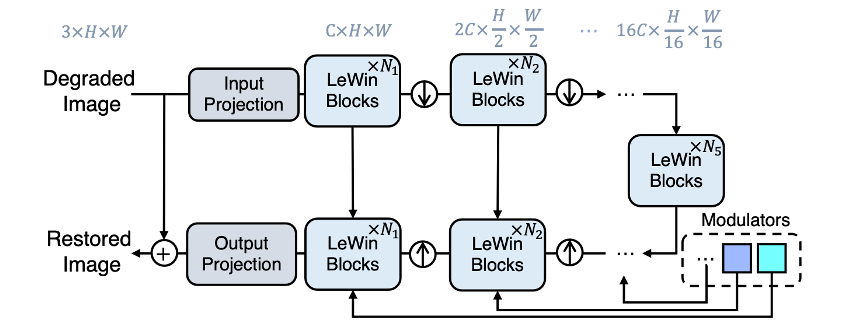

In [ ]:
class Decoder(nn.Module):
  def __init__(self,image_channels,features_channels,window_size,num_heads,list_out):
    super(Decoder,self).__init__()

    self.upsampling_1 = UpSampler(features_channels*16,features_channels*8)
    self.transformer_1 = LeWinTransformer(features_channels*16,window_size,num_heads,encoder=False)

    self.upsampling_2 = UpSampler(features_channels*16,features_channels*4)
    self.transformer_2 = LeWinTransformer(features_channels*8,window_size,num_heads,encoder=False)

    self.upsampling_3 = UpSampler(features_channels*8,features_channels*2)
    self.transformer_3 = LeWinTransformer(features_channels*4,window_size,num_heads,encoder=False)

    self.upsampling_4 = UpSampler(features_channels*4,features_channels)
    self.transformer_4 = LeWinTransformer(features_channels*2,window_size,num_heads,encoder=False)

    self.out_proj = OutputProjection(features_channels*2,image_channels)
    self.list_out = list_out
    self.len_list_out = len(list_out)

  def forward(self,x):
    print("Input feature map shape: ",x.shape)

    x = self.upsampling_1(x)
    # print("Output encoder 4 shape: ",self.list_out[-1].shape)
    print("Input decoder 1 shape: ",x.shape)
    x = torch.cat([x,self.list_out[-1]],1)
    # print("Concatenation 1 shape: ",x.shape)
    x = self.transformer_1(x)

    x = self.upsampling_2(x)
    # print("Output encoder 3 shape: ",self.list_out[-1].shape)
    print("Input decoder 2 shape: ",x.shape)
    x = torch.cat([x,self.list_out[-2]],1)
    # print("Concatenation 2 shape: ",x.shape)
    x = self.transformer_2(x)

    x = self.upsampling_3(x)
    # print("Output encoder 2 shape: ",self.list_out[-1].shape)
    print("Input decoder 3 shape: ",x.shape)
    x = torch.cat([x,self.list_out[-3]],1)
    # print("Concatenation 3 shape: ",x.shape)
    x = self.transformer_3(x)

    x = self.upsampling_4(x)
    # print("Output encoder 1 shape: ",self.list_out[-1].shape)
    print("Input decoder 4 shape: ",x.shape)
    x = torch.cat([x,self.list_out[-4]],1)
    # print("Concatenation 4 shape: ",x.shape)
    x = self.transformer_4(x)

    x = self.out_proj(x)

    return x

In [ ]:
print("Bottleneck out: ",out_btl.shape)
dec = Decoder(noisy_batch.shape[1],16,8,1,list_outs)
dec_out = dec(out_btl)
print("One step decoder: ",dec_out.shape)

Bottleneck out:  torch.Size([32, 256, 8, 8])
Input feature map shape:  torch.Size([32, 256, 8, 8])
Input decoder 1 shape:  torch.Size([32, 128, 16, 16])
Input decoder 2 shape:  torch.Size([32, 64, 32, 32])
Input decoder 3 shape:  torch.Size([32, 32, 64, 64])
Input decoder 4 shape:  torch.Size([32, 16, 128, 128])
One step decoder:  torch.Size([32, 3, 128, 128])


In [ ]:
final_restored_image = noisy_batch + dec_out

## Uformer
By placing the stage encoder, bottleneck, and stage decoder together, we obtain the Uformer architecture.

In [ ]:
class Uformer_t(nn.Module):
  def __init__(self,image_channels,features_channels,window_size,num_heads):
    super(Uformer_t,self).__init__()
    self.in_proj = InputProjection(image_channels,features_channels)

    self.transformer_01 = LeWinTransformer(features_channels,window_size,num_heads[0],encoder=True)
    self.transformer_1 = LeWinTransformer(features_channels,window_size,num_heads[0],encoder=True)
    self.downsampling_1 = DownSampler(features_channels,features_channels*2)

    self.transformer_02 = LeWinTransformer(features_channels*2,window_size,num_heads[1],encoder=True)
    self.transformer_2 = LeWinTransformer(features_channels*2,window_size,num_heads[1],encoder=True)
    self.downsampling_2 = DownSampler(features_channels*2,features_channels*4)

    self.transformer_03 = LeWinTransformer(features_channels*4,window_size,num_heads[2],encoder=True)
    self.transformer_3 = LeWinTransformer(features_channels*4,window_size,num_heads[2],encoder=True)
    self.downsampling_3 = DownSampler(features_channels*4,features_channels*8)

    self.transformer_04 = LeWinTransformer(features_channels*8,window_size,num_heads[3],encoder=True)
    self.transformer_4 = LeWinTransformer(features_channels*8,window_size,num_heads[3],encoder=True)
    self.downsampling_4 = DownSampler(features_channels*8,features_channels*16)

    self.bottleneck_0 = LeWinTransformer(features_channels*16,window_size,num_heads[4],encoder=True)
    self.bottleneck = LeWinTransformer(features_channels*16,window_size,num_heads[4],encoder=True)

    self.upsampling_1 = UpSampler(features_channels*16,features_channels*8)
    self.transformer_05 = LeWinTransformer(features_channels*16,window_size,num_heads[4],encoder=False)
    self.transformer_5 = LeWinTransformer(features_channels*16,window_size,num_heads[4],encoder=False)

    self.upsampling_2 = UpSampler(features_channels*16,features_channels*4)
    self.transformer_06 = LeWinTransformer(features_channels*8,window_size,num_heads[3],encoder=False)
    self.transformer_6 = LeWinTransformer(features_channels*8,window_size,num_heads[3],encoder=False)

    self.upsampling_3 = UpSampler(features_channels*8,features_channels*2)
    self.transformer_07 = LeWinTransformer(features_channels*4,window_size,num_heads[2],encoder=False)
    self.transformer_7 = LeWinTransformer(features_channels*4,window_size,num_heads[2],encoder=False)

    self.upsampling_4 = UpSampler(features_channels*4,features_channels)
    self.transformer_08 = LeWinTransformer(features_channels*2,window_size,num_heads[1],encoder=False)
    self.transformer_8 = LeWinTransformer(features_channels*2,window_size,num_heads[1],encoder=False)

    self.out_proj = OutputProjection(features_channels*2,image_channels)

  def forward(self,x):
    # list_out = []
    # inp_img = x
    # print("Input image shape: ",x.shape)

    proj_x = self.in_proj(x)
    # print("Projected input shape: ",x.shape)

    t01 = self.transformer_01(proj_x)
    t1 = self.transformer_1(t01)
    # list_out.append(x)
    # print("Transformer 1 shape: ",x.shape)

    d1 = self.downsampling_1(t1)
    # print("Downsampling 1 shape: ",x.shape)
    # print("Output encoder block 1: ",x.shape)

    t02 = self.transformer_02(d1)
    t2 = self.transformer_2(t02)
    # list_out.append(x)
    # print("Transformer 2 shape: ",x.shape)

    d2 = self.downsampling_2(t2)
    # print("Downsampling 2 shape: ",x.shape)
    # print("Output encoder block 1: ",x.shape)

    t03 = self.transformer_03(d2)
    t3 = self.transformer_3(t03)
    # list_out.append(x)
    # print("Transformer 3 shape: ",x.shape)

    d3 = self.downsampling_3(t3)
    # print("Downsampling 3 shape: ",x.shape)
    # print("Output encoder block 3: ",x.shape)

    t04 = self.transformer_04(d3)
    t4 = self.transformer_4(t04)
    # list_out.append(x)
    # print("Transformer 4 shape: ",x.shape)

    d5 = self.downsampling_4(t4)
    # print("Downsampling 4 shape: ",x.shape)
    # print("Output encoder block 4: ",x.shape)

    btl_0 = self.bottleneck_0(d5)
    btl = self.bottleneck(btl_0)
    # print("Downsampling 4 shape: ",x.shape)
    # print("Output bottleneck block: ",x.shape)

    u1 = self.upsampling_1(btl)
    # print("Output encoder 4 shape: ",self.list_out[-1].shape)
    # print("Input decoder 1 shape: ",x.shape)
    # x = torch.cat([x,list_out[-1]],1)
    skip1 = torch.cat([u1,t4],1)
    # print("Concatenation 1 shape: ",x.shape)
    t05 = self.transformer_05(skip1)
    t5 = self.transformer_5(t05)

    u2 = self.upsampling_2(t5)
    # print("Output encoder 3 shape: ",self.list_out[-1].shape)
    # print("Input decoder 2 shape: ",x.shape)
    # x = torch.cat([x,list_out[-2]],1)
    skip2 = torch.cat([u2,t3],1)
    # print("Concatenation 2 shape: ",x.shape)
    t06 = self.transformer_06(skip2)
    t6 = self.transformer_6(t06)

    u3 = self.upsampling_3(t6)
    # print("Output encoder 2 shape: ",self.list_out[-1].shape)
    # print("Input decoder 3 shape: ",x.shape)
    # x = torch.cat([x,list_out[-3]],1)
    skip3 = torch.cat([u3,t2],1)
    # print("Concatenation 3 shape: ",x.shape)
    t07 = self.transformer_07(skip3)
    t7 = self.transformer_7(t07)

    u4 = self.upsampling_4(t7)
    # print("Output encoder 1 shape: ",self.list_out[-1].shape)
    # print("Input decoder 4 shape: ",x.shape)
    # x = torch.cat([x,list_out[-4]],1)
    skip4 = torch.cat([u4,t1],1)
    # print("Concatenation 4 shape: ",x.shape)
    t08 = self.transformer_08(skip4)
    t8 = self.transformer_8(t08)

    out = self.out_proj(t8)

    return out + x

In order to implement a sanity check, an element of the train dataloader is subjected to arching. Of course the output will not be as hoped, but this step is important to check that everything is working well in the overall.

Noisy image shape:  torch.Size([32, 3, 128, 128])


Restored image shape:  torch.Size([32, 3, 128, 128])


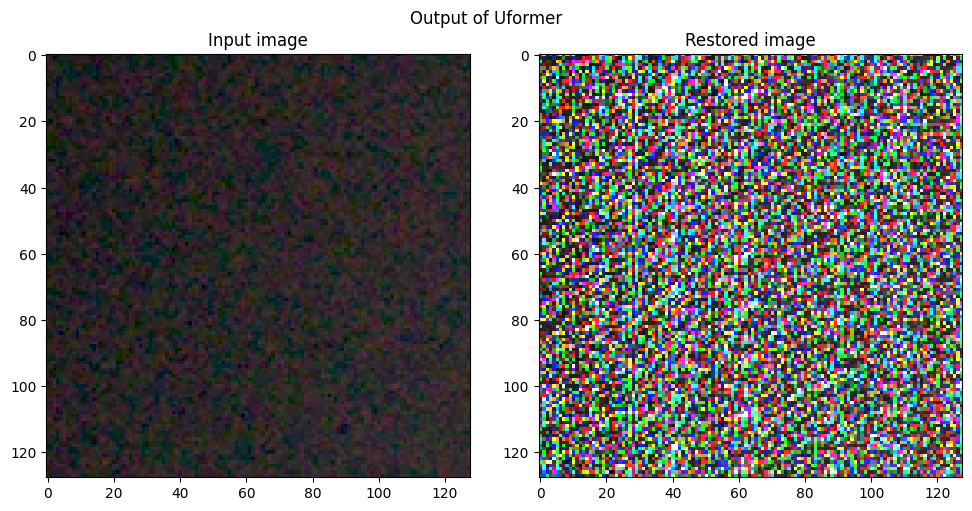

In [ ]:
print("Noisy image shape: ", noisy_batch.shape)
ufo = Uformer_t(noisy_batch.shape[1],16,8,[1,2,4,8,16])
restored = ufo(noisy_batch)
print("Restored image shape: ", restored.shape)

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Output of Uformer")
ax[0].set_title("Input image")
ax[0].imshow(noisy_batch[0].permute(1,2,0))

ax[1].set_title("Restored image")
ax[1].imshow(restored[0].detach().permute(1,2,0))

fig.tight_layout()
plt.show()

# Train
This section presents the training phase and its results. Two trains will be performed: one for Uformer with Modulator, and one for Uformer without Modulator.

## Train algorithm
This code implements the classical train approach of neural networks. We specify how, the trained model is precisely Uformer-T, the lightest version of the architecture presented in [1]. The reason for this choice lies in the few computational resources at our disposal, a context that will also influence other hyperparameters of the network.

The Uformer-T model is initialized, before the train, according to the following hyperparameters:

* The encoder and decoder have a depth of $4$ stages (LeWin Transformer + Down/Up-Sampling)
* The $C$ channels are set to $16$
* The number of heads of each multi-head attention module is $[1,2,4,8]$ for the Transformer blocks of both the encoder and decoder. For bottleneck, this hyperparameter is set to $16$. This allocation is due to the previously commented fact of keeping the size of the attention module head equal to the number of channels.
* The window size is equal to $8\times 8$
* Each LeWin Transformer block has depth $2$, so its internal structure will be repeated twice.
* Patch size is equal to $128\times 128$

The train settings are as follows:

* Batch size for the train equals $32$
* Batch size for the evaluation equal to $8$
* AdamW as an optimiser, having $(0.9, 0.999)$ as moment terms and weight decay of $0.02$
* Approach cosine decay to decrease the learning rate from $2*10^{-4}$ to $1*10^{-6}$.
* Number of epochs equal to $50$, reduced from that of [1] for the above reasons.

In [ ]:
def train(device,model, optimizer,scheduler,criterion,train_dataloader,test_dataloader,no_mod):
  # Globals
  history = {'train_loss': [], 'val_loss': [], 'lrs': []}
  train_loss_list = []
  test_loss_list = []

  if global_var['do_print_model']:
    if(no_mod):
      print_model(model, device, input_shape=[global_var['RGB_img_res'][0],global_var['patch_size'],global_var['patch_size']],path=save_model_root_nomod, name="model_summary_nomod")
      removed_modulator_parameters = remove_modulator_parameters(model)
      print('The {} model has: {} trainable parameters'.format(model_name, count_parameters(model)-removed_modulator_parameters))
    else:
      print_model(model, device, input_shape=[global_var['RGB_img_res'][0],global_var['patch_size'],global_var['patch_size']],path=save_model_root,name="model_summary")
      print('The {} model has: {} trainable parameters'.format(model_name, count_parameters(model)))

  print("--- Start training: {} ---\n".format(model_name))
  # Train

  for epoch in range(global_var['epochs']):
    iter = 1
    model.train()
    running_loss = 0

    with tqdm(train_dataloader, unit="step", position=0, leave=True) as tepoch:
      for batch in tepoch:
        tepoch.set_description(f"Epoch {epoch + 1}/{global_var['epochs']} - Training")

        # Load data
        inputs, targets = batch[0].to(device), batch[1].to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward
        loss.backward()
        optimizer.step()

        # Evaluation and Stats
        running_loss += loss.item()
        train_loss_list.append(loss.item())

        # tepoch.set_postfix({'Loss': running_loss / iter, 'Lr': global_var['lr'] if not history['lrs'] else history['lrs'][-1]})
        tepoch.set_postfix({'Loss': running_loss / iter, 'Lr': get_lr(optimizer)})
        iter += 1

    # Validation
    iter = 1
    model.eval()
    test_loss = 0
    with tqdm(test_dataloader, unit="step", position=0, leave=True) as tepoch:
      for batch in tepoch:
        tepoch.set_description(f"Epoch {epoch + 1}/{global_var['epochs']} - Validation")
        inputs, targets = batch[0].to(device=device), batch[1].to(device=device)

        # Validation loop
        with torch.no_grad():
          outputs = model(inputs)

          # Loss
          loss = criterion(outputs, targets)
          test_loss += loss.item()
          test_loss_list.append(loss.item())

          tepoch.set_postfix({'Loss': test_loss / iter})
          iter += 1

    if epoch % 5 == 0:
      scheduler.step()

    # Update history infos
    history['train_loss'].append(running_loss / len(train_dataloader))
    history['val_loss'].append(test_loss / len(test_dataloader))
    history['lrs'].append(global_var['lr'] if not history['lrs'] else history['lrs'][-1])

    if(no_mod):
      save_checkpoint(model, model_name + '_checkpoint_nomod',save_model_root_nomod)
    else:
      save_checkpoint(model, model_name + '_checkpoint',save_model_root)
    # Empty CUDA cache
    torch.cuda.empty_cache()

  print('--- Finished Training ---')

  if(no_mod):
    save_history(history, save_model_root_nomod + model_name + '_history_nomod')
    np.save(save_model_root_nomod + 'train_nomod.npy', np.array(train_loss_list))
    np.save(save_model_root_nomod + 'test_nomod.npy', np.array(test_loss_list))
  else:
    save_history(history, save_model_root + model_name + '_history')
    np.save(save_model_root + 'train.npy', np.array(train_loss_list))
    np.save(save_model_root + 'test.npy', np.array(test_loss_list))

  return history,train_loss_list, test_loss_list

## With modulator

In [ ]:
device = hardware_check()

uformer_num_heads = [1,2,4,8,16] # In order to mantain always head_dim = channels as paper sayds
uformer_fetures_channels = 16 # As we are implementing Uformer-T (tiny)
window_size = 8 # As paper says

model = Uformer(global_var['RGB_img_res'][0],uformer_fetures_channels,window_size,uformer_num_heads)
model.to(device)

criterion = Cha_loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=global_var['lr'], betas=(0.9, 0.999), weight_decay=0.02)

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, global_var['epochs'], eta_min=1e-6, last_epoch=-1, verbose=False)

stats = train(device,model,optimizer,scheduler,criterion,train_loader,test_loader,False)

Actual device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


                                                        Kernel Shape  \
Layer                                                                  
0_in_proj.Conv2d_low_level_filter                      [3, 16, 3, 3]   
1_in_proj.LeakyReLU_proj_act                                       -   
2_transformer_01.LayerNorm_layer_norm_1                         [16]   
3_transformer_01.wind_attn.qkv.Linear_get_qkv               [16, 48]   
4_transformer_01.wind_attn.Softmax_get_attentio...                 -   
5_transformer_01.wind_attn.Dropout_drop_1                          -   
6_transformer_01.wind_attn.Linear_proj                      [16, 16]   
7_transformer_01.wind_attn.Dropout_drop_2                          -   
8_transformer_01.LayerNorm_layer_norm_2                         [16]   
9_transformer_01.leff.Linear_fc1                            [16, 16]   
10_transformer_01.leff.GELU_act_1                                  -   
11_transformer_01.leff.Conv2d_conv                    [16, 16, 3

Epoch 50/50 - Validation: 100%|██████████| 8/8 [00:42<00:00,  5.26s/step, Loss=0.0378]


--- Finished Training ---


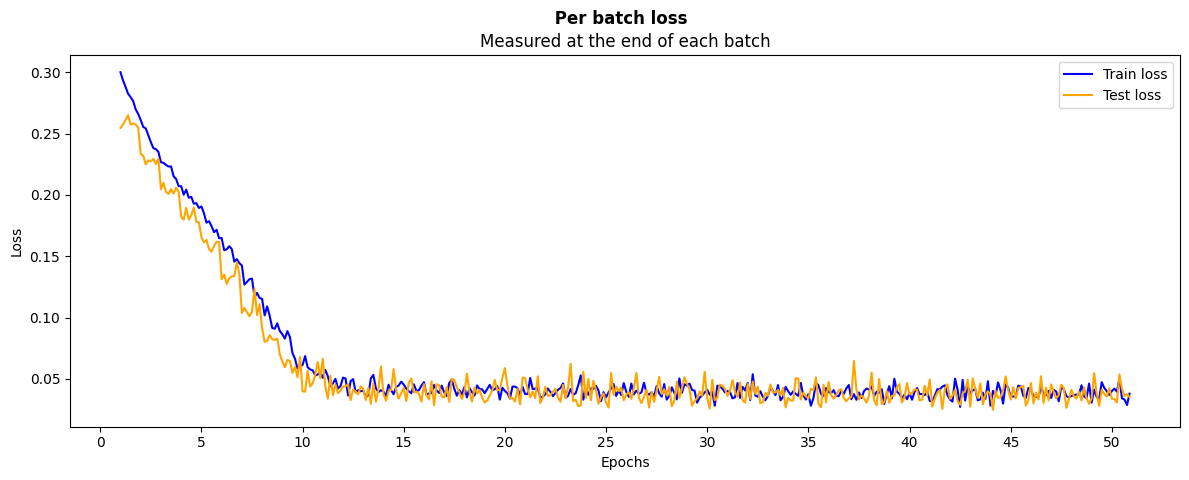

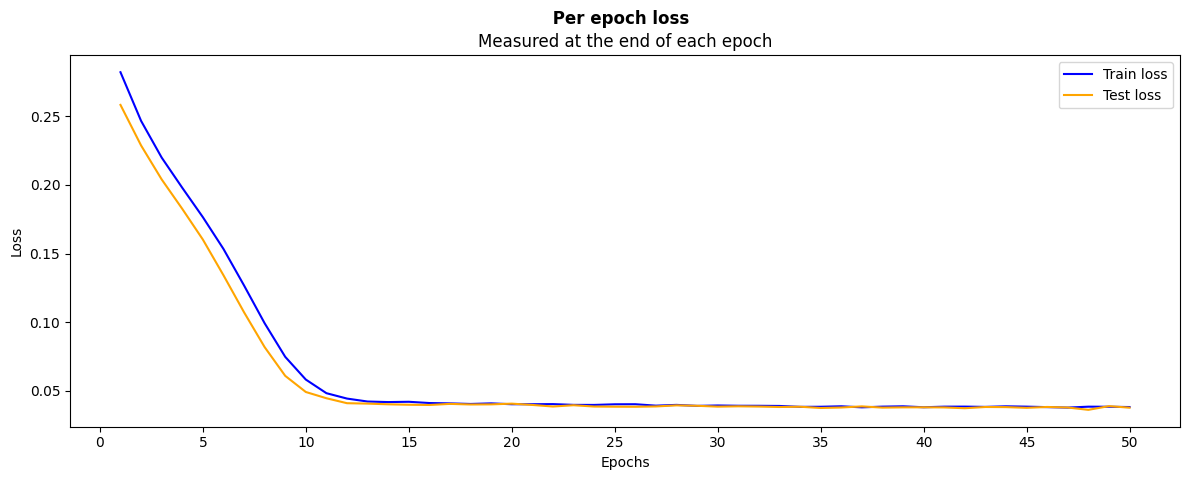

In [ ]:
with open(save_model_root+ model_name + '_history.pkl', 'rb') as f:
  mod_history = pickle.load(f)

ep_train_losses = mod_history['train_loss']
ep_test_losses = mod_history['val_loss']

b_train_losses = np.load(save_model_root + "train.npy")
b_test_losses = np.load(save_model_root + "test.npy")

fig, ax = plt.subplots(1, 1, figsize=(12,5))
fig.suptitle("         Per batch loss",fontweight="bold",y=0.95)

batch_for_epochs = np.arange(1, global_var['epochs']+1, 0.125) # from 1 to 2 with 8 (=train_set_len/train_batch_size) intermediate steps
plot_epochs = np.arange(1,global_var['epochs']+1)
plot_xticks = range(0, global_var['epochs']+1,5)

ax.set_title("Measured at the end of each batch")
ax.plot(batch_for_epochs,b_train_losses, color='blue', label="Train loss")
ax.plot(batch_for_epochs,b_test_losses, color='orange', label="Test loss")
ax.set_xticks(plot_xticks)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.legend()

fig.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(12,5))
fig.suptitle("         Per epoch loss",fontweight="bold",y=0.95)

batch_for_epochs = np.arange(1, global_var['epochs']+1, 0.125) # from 1 to 2 with 8 (=train_set_len/train_batch_size) intermediate steps
plot_xticks = range(0, global_var['epochs']+1,5)

ax.set_title("Measured at the end of each epoch")
ax.plot(plot_epochs,ep_train_losses, color='blue', label="Train loss")
ax.plot(plot_epochs,ep_test_losses, color='orange', label="Test loss")
ax.set_xticks(plot_xticks)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.legend()

fig.tight_layout()

## Without modulator

In [ ]:
device = hardware_check()

uformer_num_heads = [1,2,4,8,16] # In order to mantain always head_dim = channels as paper sayds
uformer_fetures_channels = 16 # As we are implementing Uformer-T (tiny)
window_size = 8 # As paper says

model_nomod = Uformer(global_var['RGB_img_res'][0],uformer_fetures_channels,window_size,uformer_num_heads,no_mod=True)
model_nomod.to(device)

criterion = Cha_loss()
optimizer = torch.optim.AdamW(model_nomod.parameters(), lr=global_var['lr'], betas=(0.9, 0.999), weight_decay=0.02)

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, global_var['epochs'], eta_min=1e-6, last_epoch=-1, verbose=False)

stats = train(device,model_nomod,optimizer,scheduler,criterion,train_loader,test_loader,True)

Actual device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


                                                        Kernel Shape  \
Layer                                                                  
0_in_proj.Conv2d_low_level_filter                      [3, 16, 3, 3]   
1_in_proj.LeakyReLU_proj_act                                       -   
2_transformer_01.LayerNorm_layer_norm_1                         [16]   
3_transformer_01.wind_attn.qkv.Linear_get_qkv               [16, 48]   
4_transformer_01.wind_attn.Softmax_get_attentio...                 -   
5_transformer_01.wind_attn.Dropout_drop_1                          -   
6_transformer_01.wind_attn.Linear_proj                      [16, 16]   
7_transformer_01.wind_attn.Dropout_drop_2                          -   
8_transformer_01.LayerNorm_layer_norm_2                         [16]   
9_transformer_01.leff.Linear_fc1                            [16, 16]   
10_transformer_01.leff.GELU_act_1                                  -   
11_transformer_01.leff.Conv2d_conv                    [16, 16, 3

Epoch 50/50 - Validation: 100%|██████████| 8/8 [00:42<00:00,  5.36s/step, Loss=0.0363]


--- Finished Training ---


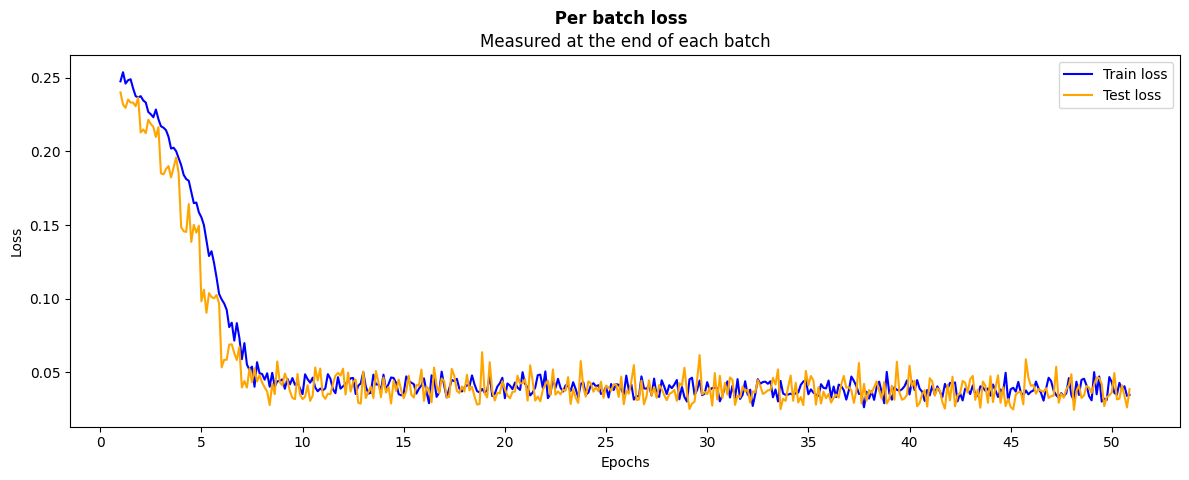

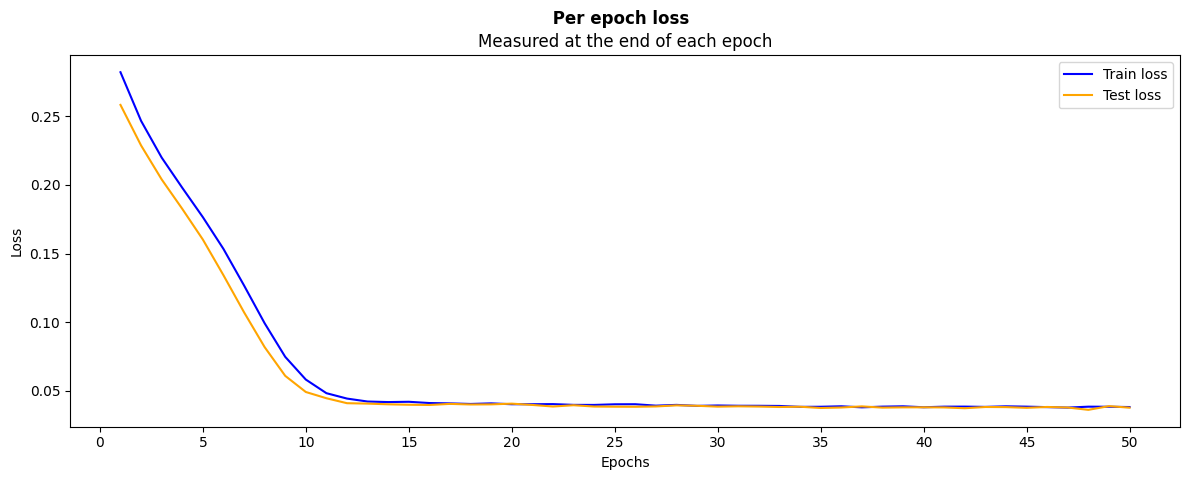

In [ ]:
with open(save_model_root_nomod+ model_name + '_history_nomod.pkl', 'rb') as f:
  nomod_history = pickle.load(f)

nomod_ep_train_losses = nomod_history['train_loss']
nomod_ep_test_losses = nomod_history['val_loss']

nomod_b_train_losses = np.load(save_model_root_nomod + "train_nomod.npy")
nomod_b_test_losses = np.load(save_model_root_nomod + "test_nomod.npy")


fig, ax = plt.subplots(1, 1, figsize=(12,5))
fig.suptitle("         Per batch loss",fontweight="bold",y=0.95)

batch_for_epochs = np.arange(1, global_var['epochs']+1, 0.125) # from 1 to 2 with 8 (=train_set_len/train_batch_size) intermediate steps
plot_epochs = np.arange(1,global_var['epochs']+1)
plot_xticks = range(0, global_var['epochs']+1,5)

ax.set_title("Measured at the end of each batch")
ax.plot(batch_for_epochs,nomod_b_train_losses, color='blue', label="Train loss")
ax.plot(batch_for_epochs,nomod_b_test_losses, color='orange', label="Test loss")
ax.set_xticks(plot_xticks)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.legend()

fig.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(12,5))
fig.suptitle("         Per epoch loss",fontweight="bold",y=0.95)

batch_for_epochs = np.arange(1, global_var['epochs']+1, 0.125) # from 1 to 2 with 8 (=train_set_len/train_batch_size) intermediate steps
plot_xticks = range(0, global_var['epochs']+1,5)

ax.set_title("Measured at the end of each epoch")
ax.plot(plot_epochs,ep_train_losses, color='blue', label="Train loss")
ax.plot(plot_epochs,ep_test_losses, color='orange', label="Test loss")
ax.set_xticks(plot_xticks)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.legend()

fig.tight_layout()

A quick analysis of the loss trend shows us that, with the absence of the Modulator, the graph is slightly noisier than in the case with the Modulator.

# Test

## PSNR and SSIM
The values of the evaluation measures certainly do not reflect those in [1].

However, this was to be expected due to the limited computational resources at our disposal, which led us to lower values, such as the number of epochs, which would perhaps have allowed the network to learn better.

Finally, analyzing the numerical values of the SSIM index, we confirm how the application of the Modulators has a positive, even if minimal, influence on the measurement, consistent with what was shown in [1].

In [ ]:
def test(model,device,test_dataloader):
  print(" --- Begin evaluation --- ")
  mean_psnr, mean_ssim = compute_evaluation(test_dataloader,model,device)
  print("Mean PSNR: ",mean_psnr)
  print("Mean SSIM: ",mean_ssim)
  print(" --- End evaluation --- ")

In [ ]:
device = hardware_check()
uformer_num_heads = [1,2,4,8,16] # In order to mantain always head_dim = channels as paper sayds
uformer_fetures_channels = 16 # As we are implementing Uformer-T (tiny)
window_size = 8 # As paper says

test_model_mod = Uformer(global_var['RGB_img_res'][0],uformer_fetures_channels,window_size,uformer_num_heads)
test_model_nomod = Uformer(global_var['RGB_img_res'][0],uformer_fetures_channels,window_size,uformer_num_heads,no_mod=True)

mod_checkpoint_path = save_model_root + "Uformer_checkpoint"
nomod_checkpoint_path = save_model_root_nomod + "Uformer_checkpoint_nomod"

print("--------- [Test] Uformer with modulators ---------")
test_model_mod = load_pretrained_model(test_model_mod,device,mod_checkpoint_path)
test_model_mod.to(device)
test(test_model_mod,device,test_loader)
torch.cuda.empty_cache()
print("--------------------------------------------------")

print("--------- [Test] Uformer without modulators ---------")
test_model_nomod = load_pretrained_model(test_model_nomod,device,nomod_checkpoint_path)
test_model_nomod.to(device)
test(test_model_nomod,device,test_loader)
torch.cuda.empty_cache()
print("--------------------------------------------------")

Actual device:  cuda:0
--------- [Test] Uformer with modulators ---------
Loading checkpoint...

Checkpoint loaded!

 --- Begin evaluation --- 
Mean PSNR:  25.738828659057617
Mean SSIM:  0.557125449180603
 --- End evaluation --- 
--------------------------------------------------
--------- [Test] Uformer without modulators ---------
Loading checkpoint...

Checkpoint loaded!

 --- Begin evaluation --- 
Mean PSNR:  25.690509796142578
Mean SSIM:  0.555575430393219
 --- End evaluation --- 
--------------------------------------------------


## Restored images
The output of Uformer, both with and without Modulator, is still quite noisy. However, this can be associated with the causes mentioned above.

In comparison to the initial case shown in the _Detailed Architecture_ section, we can see, at least, that the network has certainly learned to reconstruct the input, managing to remove even a minimal amount of noise.

In [ ]:
# Get the dataset check sample
ns_img = mpimg.imread(ns_path)
ns_dev = ns.to(device)

mod_out = test_model_mod(ns_dev.unsqueeze(0))
nomod_out = test_model_nomod(ns_dev.unsqueeze(0))

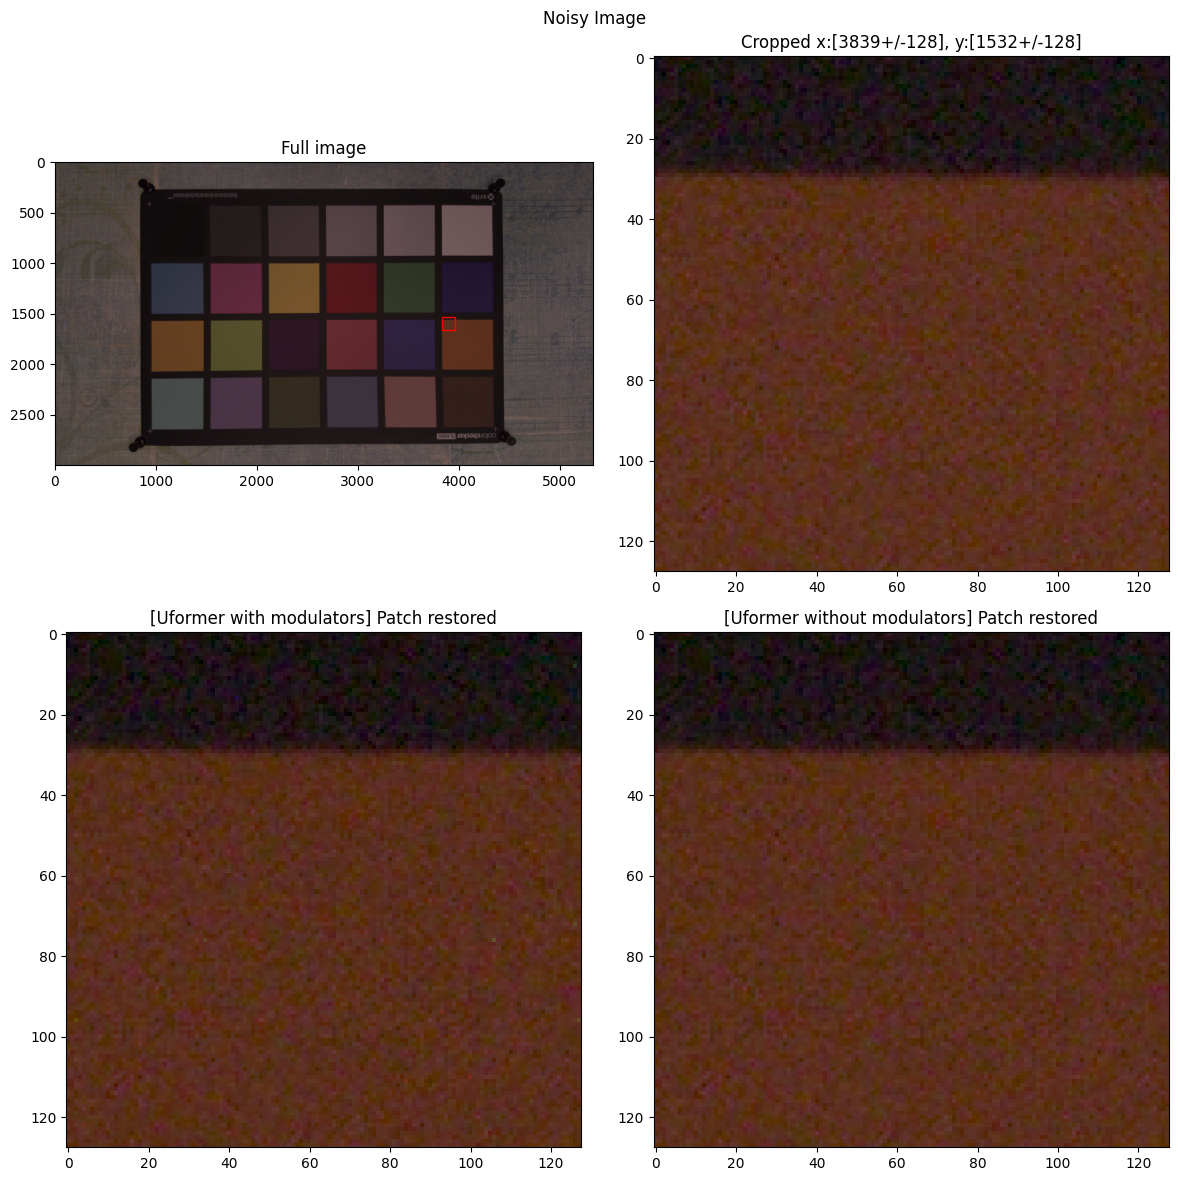

In [ ]:
x_start = crop_x[0]
y_start = crop_y[0]
rect = patches.Rectangle((x_start, y_start), global_var['patch_size'], global_var['patch_size'], linewidth=1, edgecolor='r', facecolor='none')

fig, ax = plt.subplots(2,2,figsize=(12,12))
fig.suptitle("Noisy Image")
ax[0,0].set_title("Full image")
ax[0,0].imshow(ns_img)
ax[0,0].add_patch(rect)

ax[0,1].set_title("Cropped x:[%d+/-%d], y:[%d+/-%d]" % (x_start,global_var['patch_size'],y_start,global_var['patch_size']))
ax[0,1].imshow(ns.permute(1,2,0))

ax[1,0].set_title("[Uformer with modulators] Patch restored")
ax[1,0].imshow(mod_out.detach().cpu().squeeze(0).permute(1,2,0))

ax[1,1].set_title("[Uformer without modulators] Patch restored")
ax[1,1].imshow(nomod_out.detach().cpu().squeeze(0).permute(1,2,0))

fig.tight_layout()
plt.show()

# Future works

Given the window attention approach to reduce the computational cost of attention operation, an interesting in-depth study will apply, in a coherent manner, the strategy tested in [8]. Such applications have yielded good results in the task of depth estimation and the basic methods proposed in [9,10], are certainly a starting point for further investigation.

# References

[1] Z. Wang, X. Cun, J. Bao, W. Zhou, J. Liu and H. Li, "Uformer: A General U-Shaped Transformer for Image Restoration" 2022 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), New Orleans, LA, USA, 2022, pp. 17662-17672, doi: 10.1109/CVPR52688.2022.01716.

[2] A. Abdelhamed, S. Lin and M. S. Brown, "A High-Quality Denoising Dataset for Smartphone Cameras," 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition, Salt Lake City, UT, USA, 2018, pp. 1692-1700, doi: 10.1109/CVPR.2018.00182.

[3] Tobias Plötz and Stefan Roth Benchmarking Denoising Algorithms with Real Photographs CVPR 2017

[4] Zhou Wang, A. C. Bovik, H. R. Sheikh and E. P. Simoncelli, "Image quality assessment: from error visibility to structural similarity," in IEEE Transactions on Image Processing, vol. 13, no. 4, pp. 600-612, April 2004, doi: 10.1109/TIP.2003.819861.

[5] D. M. Rouse and S. S. Hemami, "Understanding and simplifying the structural similarity metric," 2008 15th IEEE International Conference on Image Processing, San Diego, CA, USA, 2008, pp. 1188-1191, doi: 10.1109/ICIP.2008.4711973.

[6] Syed Waqas Zamir, Aditya Arora, Salman Khan, Munawar Hayat, Fahad Shahbaz Khan, Ming-Hsuan Yang, and Ling Shao. Learning Enriched Features for Real Image Restoration and Enhancement. In ECCV, 2020.

[7] Ashish Vaswani et al. “Attention is all you need”. In: Advances in Neural
Information Processing Systems. 2017, pp. 5998–6008.

[8] Claudio Schiavella, Lorenzo Cirillo, Lorenzo Papa, Paolo Russo, and Irene Amerini, "Optimize Vision Transformer architecture via efficient attention modules: a study on the
monocular depth estimation task", In: ICIAP/CVEMP Computer Vision for Environment Monitoring and Preservation 2023.

[9] Weihao Yu et al. “Metaformer is actually what you need for vision”. In:
Proceedings of the IEEE/CVF conference on computer vision and pattern
recognition. 2022, pp. 10819–10829.

[10] Wenhai Wang et al. “Pyramid vision transformer: A versatile backbone for
dense prediction without convolutions”. In: Proceedings of the IEEE/CVF
international conference on computer vision. 2021, pp. 568–578.